<a href="https://colab.research.google.com/github/AndresMontesDeOca/FundamentosML/blob/master/Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

#### Universidad Austral<br>
#### Maestría en Minería de Datos y Gestión del Conocimiento<br>
#### Análisis de Series Temporales<br>
#### Demanda Eléctrica en Uruguay<br>


#### Integrantes:<br>
Alejandra Reyes<br>
Andres Montes de Oca<br>
Rafael Gimenez<br>
Soledad Ríos<br>
Tomas Sauro

</center>

## Librerias

In [ ]:
# Verificación e instalación
import importlib
import subprocess

def instalar_librerias(packages):
    [importlib.import_module(package) if package in locals() else subprocess.call(['pip', 'install', package]) for package in packages]

# Lista de librerías a verificar e instalar
listado_librerias = ['requests', 'json', 'datetime', 'gdown', 'numpy', 'pandas', 'seaborn', 'matplotlib', 'tabulate', 'scikit-learn', 'nltk', 'optuna', 'lightgbm', 'scipy']

# Verificar e instalar las librerías
instalar_librerias(listado_librerias)

In [ ]:
# Importación
import requests
from io import BytesIO
from datetime import datetime
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

# Ignorar Warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Acceso a los datos



In [ ]:
# URLs
urls = [
    "https://onedrive.live.com/download?resid=B5CCCD69939F6AA3%211005&authkey=!AHrqM5uDXJHb9f8&em=x&app=Excel",
    "https://onedrive.live.com/download?resid=B5CCCD69939F6AA3%211006&authkey=!APCDAiw_xs74xf8&em=x&app=Excel"
]

# Descarga de datos y carga en DataFrames
dataframes = [pd.read_excel(BytesIO(requests.get(url).content)) for url in urls]

# Nombres df
df_demanda_viento, df_temperatura = dataframes

# Previsualización
print("### DataFrame de demanda y viento:")
print(df_demanda_viento.head().to_markdown(index=False))
print("\n### DataFrame de temperatura:")
print(df_temperatura.head().to_markdown(index=False))


### DataFrame de demanda y viento:
| data_hora     |   Demanda_MW |   Vel_viento |
|:--------------|-------------:|-------------:|
| 2015-10-01 02 |     1032.75  |     29.9014  |
| 2015-10-01 03 |      960.612 |     17.3043  |
| 2015-10-01 04 |      938.912 |      8.70946 |
| 2015-10-01 05 |      943.277 |      7.25391 |
| 2015-10-01 06 |      977.781 |     16.47    |

### DataFrame de temperatura:
| Fecha               |   TempAire |
|:--------------------|-----------:|
| 2020-01-01 00:00:00 |       21   |
| 2020-01-01 01:00:00 |       21   |
| 2020-01-01 02:00:00 |       20.8 |
| 2020-01-01 03:00:00 |       20.6 |
| 2020-01-01 04:00:00 |       20.6 |


## 2. Exploración Inicial sobre Demanda y Velocidad



In [ ]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Información General
print(df_demanda_viento.info())

# Resumen descriptivo
print(df_demanda_viento.describe())

# Reestablecer notación científica
pd.reset_option('display.float_format')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data_hora   65535 non-null  object 
 1   Demanda_MW  65535 non-null  float64
 2   Vel_viento  65535 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB
None
                                 Demanda_MW  \
count                             65535.000   
mean       2968922103603471429081759744.000   
std      730611400952401882395598389248.000   
min                             -555555.000   
25%                                1091.628   
50%                                1265.121   
75%                                1432.302   
max   186877000000000019090986688839680.000   

                                  Vel_viento  
count                              65535.000  
mean       28572930498310260279209885696.000  
std      6903114358998181710542512586752.000  
min               

In [ ]:
# Convertir la columna 'data_hora' a tipo datetime
df_demanda_viento['data_hora'] = pd.to_datetime(df_demanda_viento['data_hora'])
df_demanda_viento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_hora   65535 non-null  datetime64[ns]
 1   Demanda_MW  65535 non-null  float64       
 2   Vel_viento  65535 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 MB


In [ ]:
df_demanda_viento.head()

data_hora   Demanda_MW  Vel_viento
0 2015-10-01 02:00:00  1032.749657   29.901389
1 2015-10-01 03:00:00   960.611900   17.304258
2 2015-10-01 04:00:00   938.911828    8.709460
3 2015-10-01 05:00:00   943.277163    7.253912
4 2015-10-01 06:00:00   977.780929   16.470050

In [ ]:
# Resumen por percentiles (10% - 90%)
df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Demanda_MW  Vel_viento
0.1   963.320548    6.269584
0.2  1049.948636    8.053771
0.3  1131.979247    9.922470
0.4  1207.205600   12.417292
0.5  1265.120510   15.552721
0.6  1323.459696   19.245680
0.7  1393.369256   23.803808
0.8  1475.123830   29.521596
0.9  1602.848296   38.107889

In [ ]:
# Resumen por percentiles (91% - 99%)
df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

Demanda_MW  Vel_viento
0.91  1618.805371   39.311099
0.92  1637.366449   40.637896
0.93  1657.382398   42.241740
0.94  1679.869551   44.151790
0.95  1703.961468   46.505453
0.96  1733.260065   49.389648
0.97  1767.140537   52.910388
0.98  1809.945472   57.389888
0.99  1880.579195   64.426435

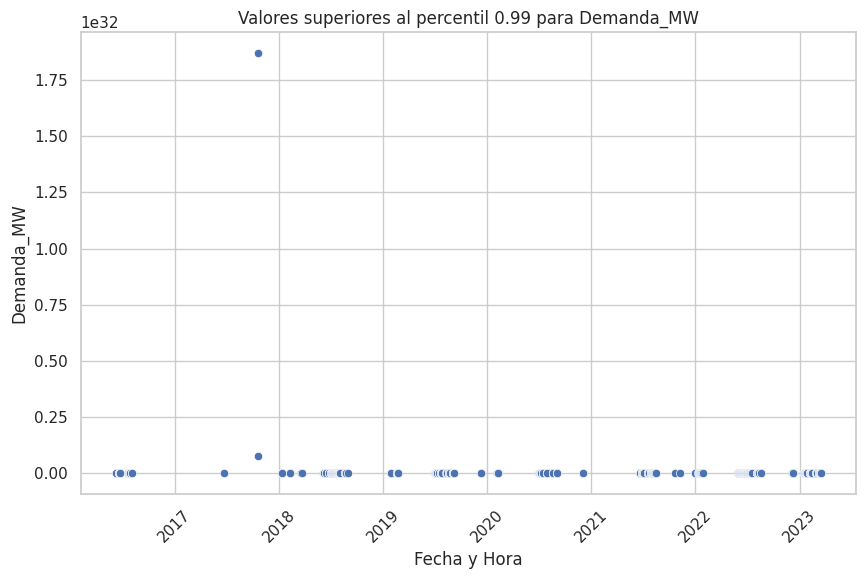

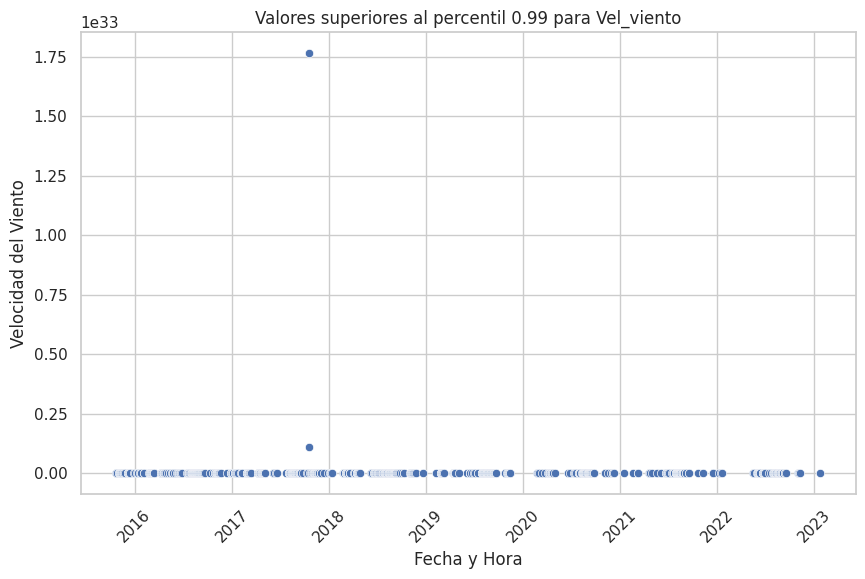

In [ ]:
# Visualizar posibles outliers (superiores)
percentiles = df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile(0.99)

# Filtrar valores superiores al percentil 0.99
df_superiores_demanda = df_demanda_viento[df_demanda_viento['Demanda_MW'] > percentiles['Demanda_MW']]
df_superiores_velocidad = df_demanda_viento[df_demanda_viento['Vel_viento'] > percentiles['Vel_viento']]

# Graficar los valores superiores al percentil 0.99 para Demanda_MW
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Demanda_MW', data=df_superiores_demanda)
plt.title('Valores superiores al percentil 0.99 para Demanda_MW')
plt.xlabel('Fecha y Hora')
plt.ylabel('Demanda_MW')
plt.xticks(rotation=45)
plt.show()

# Graficar los valores superiores al percentil 0.99 para Vel_viento
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Vel_viento', data=df_superiores_velocidad)
plt.title('Valores superiores al percentil 0.99 para Vel_viento')
plt.xlabel('Fecha y Hora')
plt.ylabel('Velocidad del Viento')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (91% - 99%)
print(df_superiores_demanda[['Demanda_MW']].quantile([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Demanda_MW
0.910    2044.228
0.920    2050.487
0.930    2061.866
0.940    2077.139
0.950    2088.430
0.960    2112.654
0.970    2125.103
0.980    2197.624
0.990    5937.088


In [ ]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (91% - 99%)
print(df_superiores_demanda[['Vel_viento']].quantile([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Vel_viento
0.910      35.049
0.920      36.825
0.930      38.681
0.940      40.867
0.950      42.344
0.960      45.134
0.970      49.491
0.980      55.914
0.990   10384.087


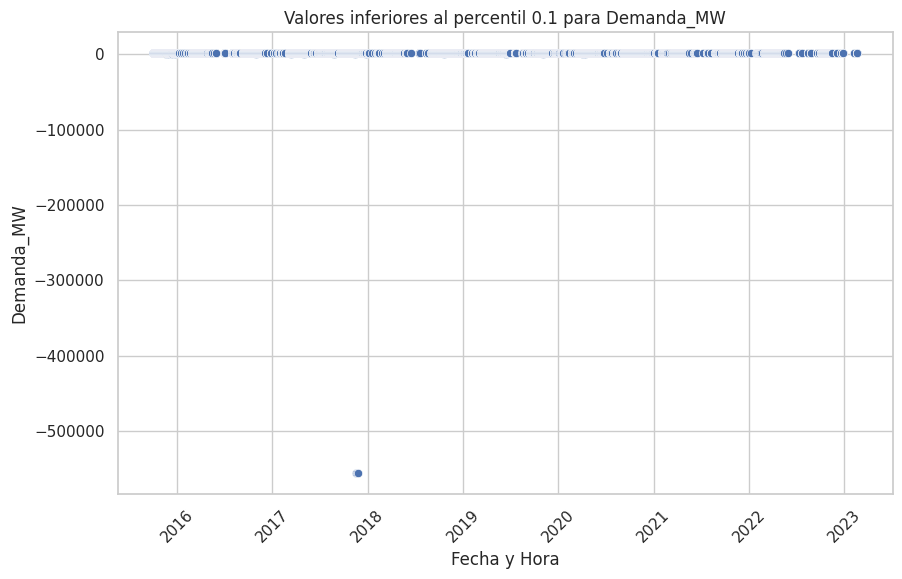

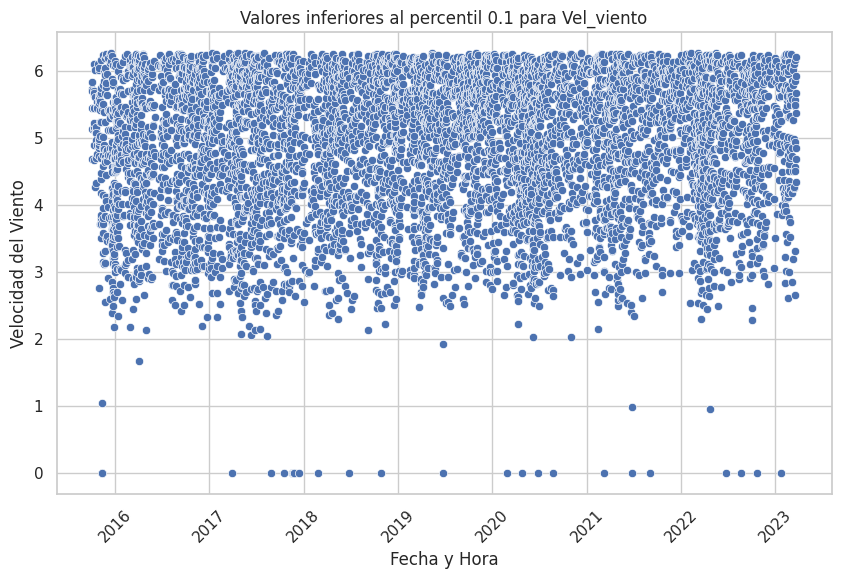

In [ ]:
# Visualizar posibles outliers (inferiores)
percentiles = df_demanda_viento[['Demanda_MW', 'Vel_viento']].quantile(0.1)

# Filtrar valores superiores al percentil 0.99
df_inferiores_demanda = df_demanda_viento[df_demanda_viento['Demanda_MW'] < percentiles['Demanda_MW']]
df_inferiores_velocidad = df_demanda_viento[df_demanda_viento['Vel_viento'] < percentiles['Vel_viento']]

# Graficar los valores inferiores al percentil 0.1 para Demanda_MW
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Demanda_MW', data=df_inferiores_demanda)
plt.title('Valores inferiores al percentil 0.1 para Demanda_MW')
plt.xlabel('Fecha y Hora')
plt.ylabel('Demanda_MW')
plt.xticks(rotation=45)
plt.show()

# Graficar los valores inferiores al percentil 0.1 para Vel_viento
plt.figure(figsize=(10, 6))
sns.scatterplot(x='data_hora', y='Vel_viento', data=df_inferiores_velocidad)
plt.title('Valores inferiores al percentil 0.1 para Vel_viento')
plt.xlabel('Fecha y Hora')
plt.ylabel('Velocidad del Viento')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (1% - 9%)
print(df_inferiores_demanda[['Demanda_MW']].quantile([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Demanda_MW
0.010     763.662
0.020     783.256
0.030     795.324
0.040     802.203
0.050     808.328
0.060     814.778
0.070     819.197
0.080     823.824
0.090     829.124


In [ ]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Resumen por percentiles (1% - 9%)
print(df_inferiores_demanda[['Vel_viento']].quantile([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]))

# Reestablecer notación científica
pd.reset_option('display.float_format')

       Vel_viento
0.010       2.692
0.020       2.977
0.030       3.233
0.040       3.498
0.050       3.721
0.060       3.909
0.070       4.103
0.080       4.276
0.090       4.487


In [ ]:
# Los datos sobre demanda y viento presentan valores atípicos;
# Para el caso de demanda se observa valores negativos y valores mayores a 2300 mWh
# Para el caso del viento se observa valores superiores a 100 km/h
# Estos valores se clasifican como erróneos por recomendación de quienes proveyeron los datos
# Por recomendacion de los proveedores del dato (Secrataria de energia del Uruguay) se imputa los valores negativos de demanda por 83 (valor minimo usual) y por 2300 los superiores a 2300
# En el caso del viento se establece como valor maximo 100 (mayor a 100 implica tornado, evento muy atipico en uruguay)

In [ ]:
# Reemplazar valores negativos en Demanda_MW por 83 y valores mayores a 2300 por 2300
# df_demanda_viento['Demanda_MW'] = df_demanda_viento['Demanda_MW'].apply(lambda x: 83 if x < 0 else (2300 if x > 2300 else x))

# MODIFICACION ANDY ->
df_demanda_viento['Demanda_MW'] = df_demanda_viento['Demanda_MW'].apply(lambda x: None if x < 600 else (None if x > 2300 else x))
df_demanda_viento['Demanda_MW'].fillna(method='backfill', inplace=True)

# Reemplazar valores mayores a 100 en Vel_viento por 100
df_demanda_viento['Vel_viento'] = df_demanda_viento['Vel_viento'].apply(lambda x: 100 if x > 100 else x)

## 2.1 Exploración Inicial sobre Temperatura



In [ ]:
# No mostrar notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Información General
print(df_temperatura.info())

# Resumen descriptivo
print(df_temperatura['TempAire'].describe())

# Reestablecer notación científica
pd.reset_option('display.float_format')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     26277 non-null  datetime64[ns]
 1   TempAire  26277 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 410.7 KB
None
count   26277.000
mean       16.559
std         5.922
min         0.000
25%        12.200
50%        16.600
75%        20.800
max        38.800
Name: TempAire, dtype: float64


In [ ]:
df_temperatura.head()

Fecha  TempAire
0 2020-01-01 00:00:00      21.0
1 2020-01-01 01:00:00      21.0
2 2020-01-01 02:00:00      20.8
3 2020-01-01 03:00:00      20.6
4 2020-01-01 04:00:00      20.6

In [ ]:
# Resumen por percentiles (10% - 90%)
df_temperatura['TempAire'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

0.1     8.8
0.2    11.2
0.3    13.1
0.4    14.8
0.5    16.6
0.6    18.4
0.7    20.0
0.8    21.8
0.9    24.1
Name: TempAire, dtype: float64

## 3. Unificacion



In [ ]:
# Union de los DataFrames usando merge y outer join
df = pd.merge(df_demanda_viento, df_temperatura, left_on='data_hora', right_on='Fecha', how='outer')

# Ordenar por la columna de fecha/hora
df = df.sort_values(by='data_hora')

# Rellenar los valores nulos con NaN
df = df.fillna(value=pd.NA)

# Previsualizacion
df.head()

data_hora   Demanda_MW  Vel_viento Fecha  TempAire
0 2015-10-01 02:00:00  1032.749657   29.901389   NaT       NaN
1 2015-10-01 03:00:00   960.611900   17.304258   NaT       NaN
2 2015-10-01 04:00:00   938.911828    8.709460   NaT       NaN
3 2015-10-01 05:00:00   943.277163    7.253912   NaT       NaN
4 2015-10-01 06:00:00   977.780929   16.470050   NaT       NaN

In [ ]:
# Limites de fecha del DataFrame df_demanda_viento
fecha_min_demanda = df_demanda_viento['data_hora'].min()
fecha_max_demanda = df_demanda_viento['data_hora'].max()
print(f"Fecha mínima en df_demanda_viento: {fecha_min_demanda}")
print(f"Fecha máxima en df_demanda_viento: {fecha_max_demanda}")

# Limites de fecha del DataFrame df_temperatura
fecha_min_temperatura = df_temperatura['Fecha'].min()
fecha_max_temperatura = df_temperatura['Fecha'].max()
print(f"Fecha mínima en df_temperatura: {fecha_min_temperatura}")
print(f"Fecha máxima en df_temperatura: {fecha_max_temperatura}")


Fecha mínima en df_demanda_viento: 2015-10-01 02:00:00
Fecha máxima en df_demanda_viento: 2023-03-23 16:00:00
Fecha mínima en df_temperatura: 2020-01-01 00:00:00
Fecha máxima en df_temperatura: 2022-12-31 23:00:00


In [ ]:
# Filtrar las fecha del dataframe unificado
df = df[(df['data_hora'] >= fecha_min_temperatura) & (df['data_hora'] <= fecha_max_temperatura)]
df = df.drop(columns=['Fecha'])

# Previsualizacion
df.head()

data_hora   Demanda_MW  Vel_viento  TempAire
37270 2020-01-01 00:00:00  1159.488814   20.097612      21.0
37271 2020-01-01 01:00:00  1081.818798    7.237234      21.0
37272 2020-01-01 02:00:00  1072.515889   10.902265      20.8
37273 2020-01-01 03:00:00  1029.419464   15.577264      20.6
37274 2020-01-01 04:00:00   979.258112   13.301302      20.6

In [ ]:
# Verificar si el dataframe esta completo (que no se omita alguna hora o dia)
fechas_esperadas = pd.date_range(start=fecha_min_temperatura, end=fecha_max_temperatura, freq='H')
todas_las_fechas_presentes = set(fechas_esperadas) == set(df['data_hora'])

if todas_las_fechas_presentes:
    print("El DataFrame tiene todas las fechas completas.")
else:
    print("El DataFrame tiene fechas faltantes.")

El DataFrame tiene todas las fechas completas.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26304 entries, 37270 to 63573
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_hora   26304 non-null  datetime64[ns]
 1   Demanda_MW  26304 non-null  float64       
 2   Vel_viento  26304 non-null  float64       
 3   TempAire    26277 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.0 MB


In [ ]:
# Imputar los valores faltantes del temperatura utilizando interpolacion lineal

# Ordenar el DataFrame
df = df.sort_values(by='data_hora')

# Imputar los valores faltantes
df['TempAire'] = df['TempAire'].interpolate()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26304 entries, 37270 to 63573
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_hora   26304 non-null  datetime64[ns]
 1   Demanda_MW  26304 non-null  float64       
 2   Vel_viento  26304 non-null  float64       
 3   TempAire    26304 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.0 MB


In [ ]:
# Renombrar las columnas
df = df.rename(columns={
    'data_hora': 'fecha_hora',
    'Demanda_MW': 'demanda',
    'Vel_viento': 'viento',
    'TempAire': 'temperatura'
})
df.head()

fecha_hora      demanda     viento  temperatura
37270 2020-01-01 00:00:00  1159.488814  20.097612         21.0
37271 2020-01-01 01:00:00  1081.818798   7.237234         21.0
37272 2020-01-01 02:00:00  1072.515889  10.902265         20.8
37273 2020-01-01 03:00:00  1029.419464  15.577264         20.6
37274 2020-01-01 04:00:00   979.258112  13.301302         20.6

In [ ]:
# Configurar 'fecha_hora' como índice
df.set_index('fecha_hora', inplace=True)
df.head()

demanda     viento  temperatura
fecha_hora                                              
2020-01-01 00:00:00  1159.488814  20.097612         21.0
2020-01-01 01:00:00  1081.818798   7.237234         21.0
2020-01-01 02:00:00  1072.515889  10.902265         20.8
2020-01-01 03:00:00  1029.419464  15.577264         20.6
2020-01-01 04:00:00   979.258112  13.301302         20.6

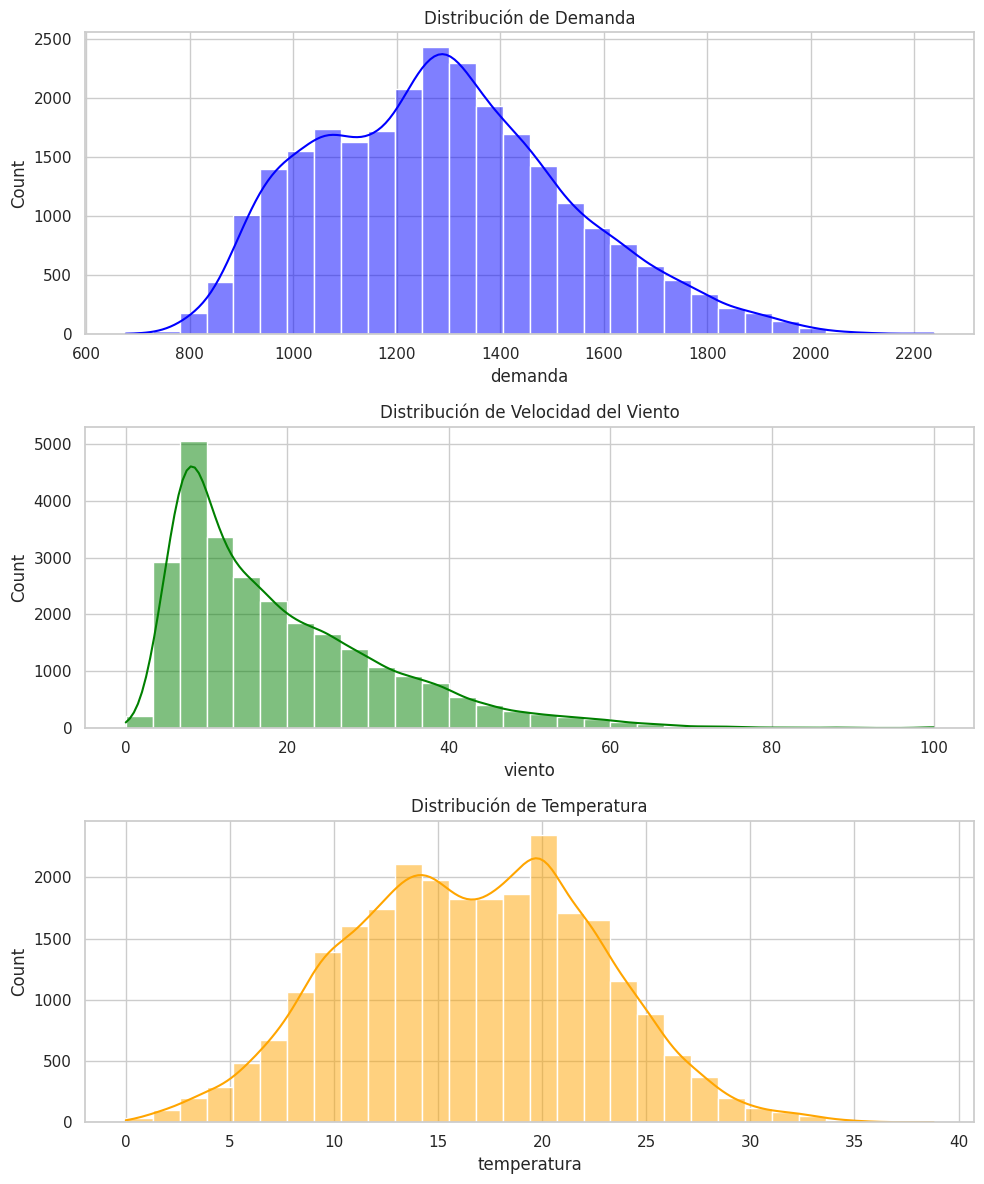

In [ ]:
# Distribucion de las variables de interes
sns.set(style="whitegrid")

# Crear subplots para la distribución de demanda, viento y temperatura
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Gráfico de distribución de la demanda
sns.histplot(df['demanda'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribución de Demanda')

# Gráfico de distribución de la velocidad del viento
sns.histplot(df['viento'], bins=30, kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribución de Velocidad del Viento')

# Gráfico de distribución de la temperatura
sns.histplot(df['temperatura'], bins=30, kde=True, color='orange', ax=axes[2])
axes[2].set_title('Distribución de Temperatura')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

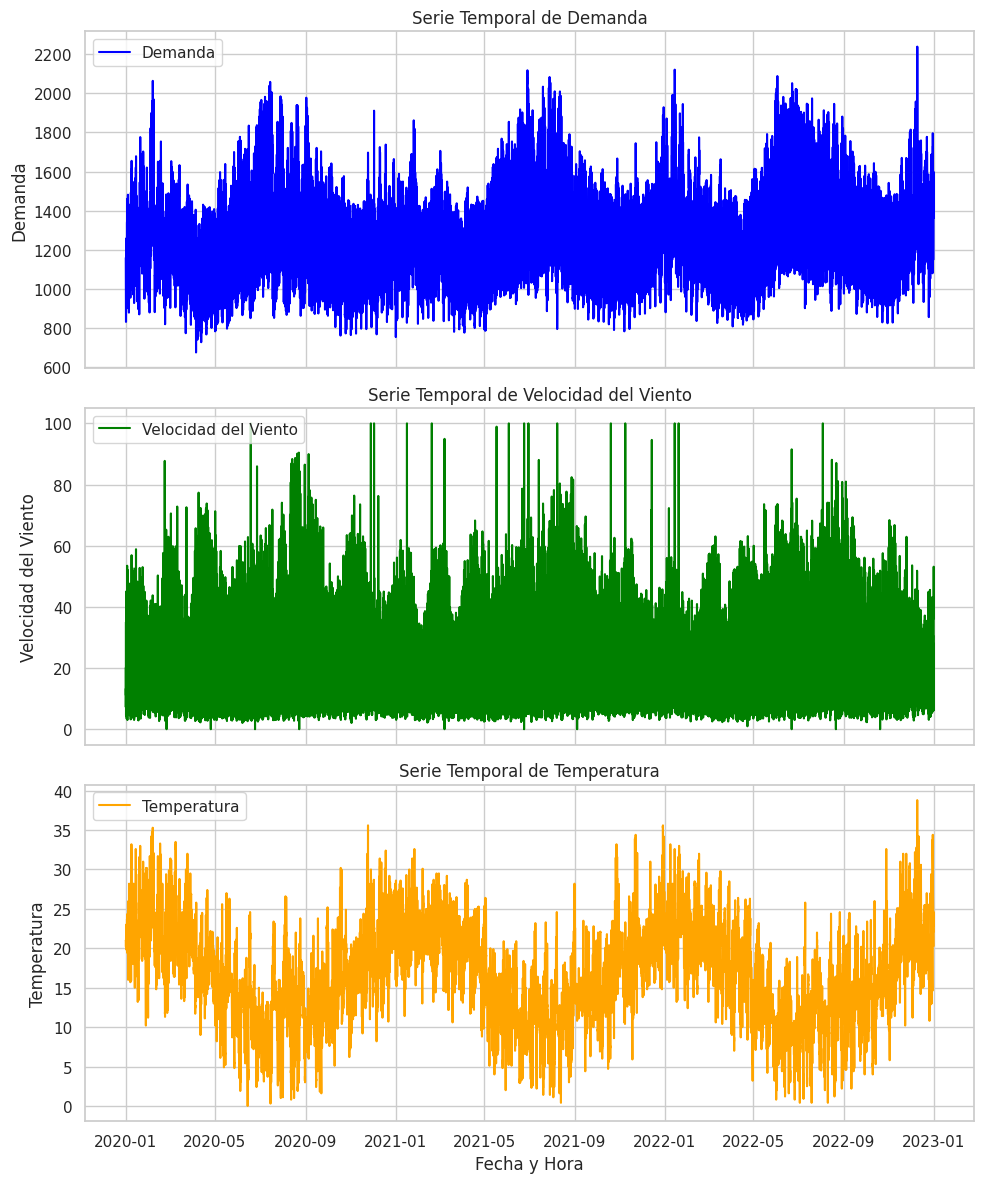

In [ ]:
# Distribucion de las variables de interes a lo largo del tiempo
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Crear subgráficos para cada serie temporal
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Gráfico de línea para la serie temporal de Demanda
sns.lineplot(x=df.index, y=df['demanda'], ax=axes[0], label='Demanda', color='blue')

# Configuraciones del gráfico de demanda
axes[0].set_title('Serie Temporal de Demanda')
axes[0].set_ylabel('Demanda')
axes[0].grid(True)
axes[0].legend()

# Gráfico de línea para la serie temporal de Velocidad del Viento
sns.lineplot(x=df.index, y=df['viento'], ax=axes[1], label='Velocidad del Viento', color='green')

# Configuraciones del gráfico de velocidad del viento
axes[1].set_title('Serie Temporal de Velocidad del Viento')
axes[1].set_ylabel('Velocidad del Viento')
axes[1].grid(True)
axes[1].legend()

# Gráfico de línea para la serie temporal de Temperatura
sns.lineplot(x=df.index, y=df['temperatura'], ax=axes[2], label='Temperatura', color='orange')

# Configuraciones del gráfico de temperatura
axes[2].set_title('Serie Temporal de Temperatura')
axes[2].set_xlabel('Fecha y Hora')
axes[2].set_ylabel('Temperatura')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

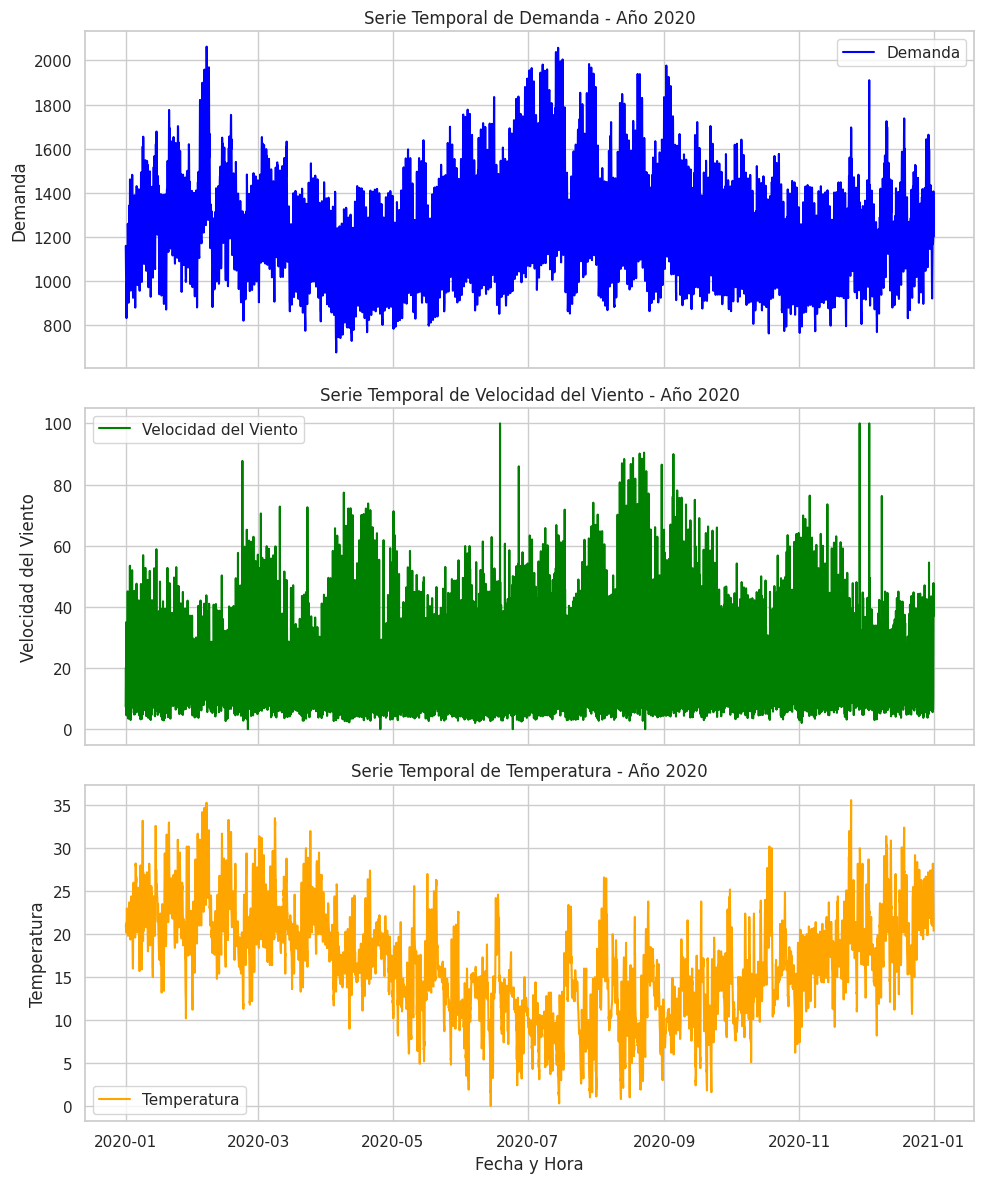

In [ ]:
# Distribucion de las variables de interes en 2020

# Filtrar el DataFrame para incluir solo el año 2020
df_2020 = df['2020-01-01':'2020-12-31']

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear subgráficos para cada serie temporal
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Gráfico de línea para la serie temporal de Demanda en 2020
sns.lineplot(x=df_2020.index, y=df_2020['demanda'], ax=axes[0], label='Demanda', color='blue')

# Configuraciones del gráfico de demanda
axes[0].set_title('Serie Temporal de Demanda - Año 2020')
axes[0].set_ylabel('Demanda')
axes[0].grid(True)
axes[0].legend()

# Gráfico de línea para la serie temporal de Velocidad del Viento en 2020
sns.lineplot(x=df_2020.index, y=df_2020['viento'], ax=axes[1], label='Velocidad del Viento', color='green')

# Configuraciones del gráfico de velocidad del viento
axes[1].set_title('Serie Temporal de Velocidad del Viento - Año 2020')
axes[1].set_ylabel('Velocidad del Viento')
axes[1].grid(True)
axes[1].legend()

# Gráfico de línea para la serie temporal de Temperatura en 2020
sns.lineplot(x=df_2020.index, y=df_2020['temperatura'], ax=axes[2], label='Temperatura', color='orange')

# Configuraciones del gráfico de temperatura
axes[2].set_title('Serie Temporal de Temperatura - Año 2020')
axes[2].set_xlabel('Fecha y Hora')
axes[2].set_ylabel('Temperatura')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

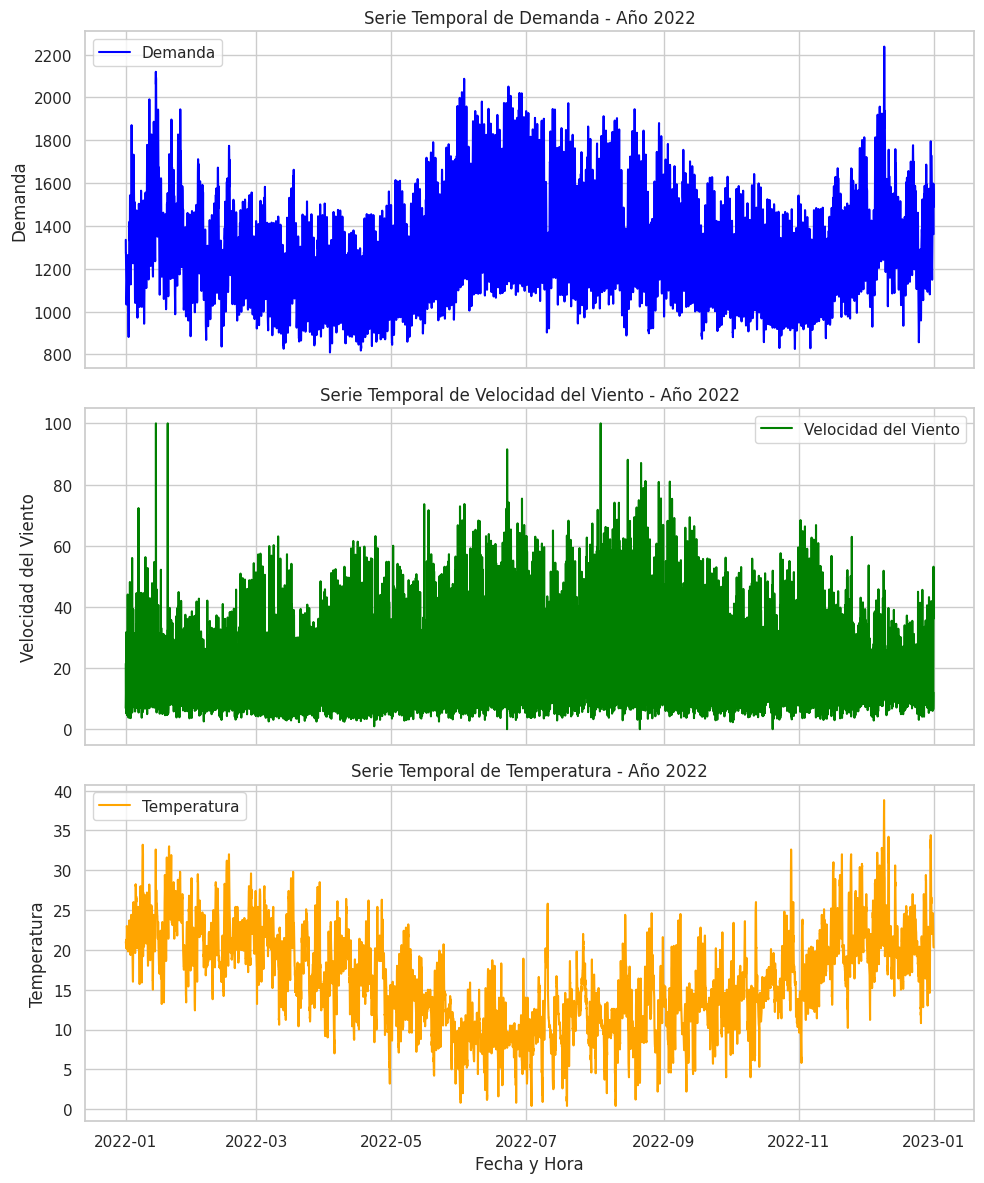

In [ ]:
# Distribucion de las variables de interes en 2022

# Filtrar el DataFrame para incluir solo el año 2022
df_2022 = df['2022-01-01':'2022-12-31']

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear subgráficos para cada serie temporal
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Gráfico de línea para la serie temporal de Demanda en 2022
sns.lineplot(x=df_2022.index, y=df_2022['demanda'], ax=axes[0], label='Demanda', color='blue')

# Configuraciones del gráfico de demanda
axes[0].set_title('Serie Temporal de Demanda - Año 2022')
axes[0].set_ylabel('Demanda')
axes[0].grid(True)
axes[0].legend()

# Gráfico de línea para la serie temporal de Velocidad del Viento en 2022
sns.lineplot(x=df_2022.index, y=df_2022['viento'], ax=axes[1], label='Velocidad del Viento', color='green')

# Configuraciones del gráfico de velocidad del viento
axes[1].set_title('Serie Temporal de Velocidad del Viento - Año 2022')
axes[1].set_ylabel('Velocidad del Viento')
axes[1].grid(True)
axes[1].legend()

# Gráfico de línea para la serie temporal de Temperatura en 2022
sns.lineplot(x=df_2022.index, y=df_2022['temperatura'], ax=axes[2], label='Temperatura', color='orange')

# Configuraciones del gráfico de temperatura
axes[2].set_title('Serie Temporal de Temperatura - Año 2022')
axes[2].set_xlabel('Fecha y Hora')
axes[2].set_ylabel('Temperatura')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

**Variables**

- **demanda**: Representa la demanda de energía en megavatios (MW) en un determinado período de tiempo.
- **viento**: Indica la velocidad del viento en un determinado momento en km/h.
- **temperatura**: Muestra la temperatura del aire en grados Celsius en un momento específico. diario.

## 4. Feature Engineering

In [ ]:
# Features tomadas y adaptadas de la practica sincronica clase 7 > ejercicio 1
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)

def add_lags(df):
    target_map = df['demanda'].to_dict()
    df['lag1d'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag7d'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag30d'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag90d'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df
df = add_lags(df)

In [ ]:
# lags por 3, 4 y 6 horas
df['lag3h'] = df['demanda'].shift(3, freq='H')
df['lag4h'] = df['demanda'].shift(4, freq='H')
df['lag6h'] = df['demanda'].shift(6, freq='H')
df.head()

demanda     viento  temperatura  hour  dayofweek  \
fecha_hora                                                                  
2020-01-01 00:00:00  1159.488814  20.097612         21.0     0          2   
2020-01-01 01:00:00  1081.818798   7.237234         21.0     1          2   
2020-01-01 02:00:00  1072.515889  10.902265         20.8     2          2   
2020-01-01 03:00:00  1029.419464  15.577264         20.6     3          2   
2020-01-01 04:00:00   979.258112  13.301302         20.6     4          2   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
fecha_hora                                                                     
2020-01-01 00:00:00        1      1  2020          1           1           1   
2020-01-01 01:00:00        1      1  2020          1           1           1   
2020-01-01 02:00:00        1      1  2020          1           1           1   
2020-01-01 03:00:00        1      1  2020          1           1           1   
2020-01-01 04:00:00        1      1  2020          1           1           1   

                     lag1d  lag7d  lag30d  lag90d        lag3h        lag4h  \
fecha_hora                                                                    
2020-01-01 00:00:00    NaN    NaN     NaN     NaN          NaN          NaN   
2020-01-01 01:00:00    NaN    NaN     NaN     NaN          NaN          NaN   
2020-01-01 02:00:00    NaN    NaN     NaN     NaN          NaN          NaN   
2020-01-01 03:00:00    NaN    NaN     NaN     NaN  1159.488814          NaN   
2020-01-01 04:00:00    NaN    NaN     NaN     NaN  1081.818798  1159.488814   

                     lag6h  
fecha_hora                  
2020-01-01 00:00:00    NaN  
2020-01-01 01:00:00    NaN  
2020-01-01 02:00:00    NaN  
2020-01-01 03:00:00    NaN  
2020-01-01 04:00:00    NaN

In [ ]:
# Crear la columna temporada y en base a ella crear temporada_calor (orden ascendente de nivel de temperatura)

# Definir las estaciones para Uruguay (considerando el hemisferio sur)
def obtener_temporada(month):
    if 1 <= month <= 2 or 12 == month:
        return 'Verano'
    elif 3 <= month <= 5:
        return 'Otoño'
    elif 6 <= month <= 8:
        return 'Invierno'
    elif 9 <= month <= 11:
        return 'Primavera'

# Crear la columna temporada
df['temporada'] = df['month'].apply(obtener_temporada)

# Crear la columna temporada_calor
def obtener_temporada_calor(temporada):
    if temporada == 'Invierno':
        return 1
    elif temporada == 'Otoño':
        return 2
    elif temporada == 'Primavera':
        return 3
    elif temporada == 'Verano':
        return 4

df['temporada_calor'] = df['temporada'].apply(obtener_temporada_calor)

# Eliminar la columna 'temporada'
df = df.drop('temporada', axis=1)
df.head()

demanda     viento  temperatura  hour  dayofweek  \
fecha_hora                                                                  
2020-01-01 00:00:00  1159.488814  20.097612         21.0     0          2   
2020-01-01 01:00:00  1081.818798   7.237234         21.0     1          2   
2020-01-01 02:00:00  1072.515889  10.902265         20.8     2          2   
2020-01-01 03:00:00  1029.419464  15.577264         20.6     3          2   
2020-01-01 04:00:00   979.258112  13.301302         20.6     4          2   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
fecha_hora                                                                     
2020-01-01 00:00:00        1      1  2020          1           1           1   
2020-01-01 01:00:00        1      1  2020          1           1           1   
2020-01-01 02:00:00        1      1  2020          1           1           1   
2020-01-01 03:00:00        1      1  2020          1           1           1   
2020-01-01 04:00:00        1      1  2020          1           1           1   

                     lag1d  lag7d  lag30d  lag90d        lag3h        lag4h  \
fecha_hora                                                                    
2020-01-01 00:00:00    NaN    NaN     NaN     NaN          NaN          NaN   
2020-01-01 01:00:00    NaN    NaN     NaN     NaN          NaN          NaN   
2020-01-01 02:00:00    NaN    NaN     NaN     NaN          NaN          NaN   
2020-01-01 03:00:00    NaN    NaN     NaN     NaN  1159.488814          NaN   
2020-01-01 04:00:00    NaN    NaN     NaN     NaN  1081.818798  1159.488814   

                     lag6h  temporada_calor  
fecha_hora                                   
2020-01-01 00:00:00    NaN                4  
2020-01-01 01:00:00    NaN                4  
2020-01-01 02:00:00    NaN                4  
2020-01-01 03:00:00    NaN                4  
2020-01-01 04:00:00    NaN                4

In [ ]:
# Promedios moviles para 4 horas, 6 horas, 1 dia, 1 semana y un mes

# Promedio móvil de 3 horas
df['demanda_promedio_3h'] = df['demanda'].rolling(window=3).mean()

# Promedio móvil de 4 horas
df['demanda_promedio_4h'] = df['demanda'].rolling(window=4).mean()

# Promedio móvil de 6 horas
df['demanda_promedio_6h'] = df['demanda'].rolling(window=6).mean()

# Promedio móvil de 1 día
df['demanda_promedio_1d'] = df['demanda'].rolling(window=24).mean()

# Promedio móvil de 7 días
df['demanda_promedio_7d'] = df['demanda'].rolling(window=24 * 7).mean()

# Promedio móvil de 30 días
df['demanda_promedio_30d'] = df['demanda'].rolling(window=24 * 30).mean()

df.head()

demanda     viento  temperatura  hour  dayofweek  \
fecha_hora                                                                  
2020-01-01 00:00:00  1159.488814  20.097612         21.0     0          2   
2020-01-01 01:00:00  1081.818798   7.237234         21.0     1          2   
2020-01-01 02:00:00  1072.515889  10.902265         20.8     2          2   
2020-01-01 03:00:00  1029.419464  15.577264         20.6     3          2   
2020-01-01 04:00:00   979.258112  13.301302         20.6     4          2   

                     quarter  month  year  dayofyear  dayofmonth  ...  \
fecha_hora                                                        ...   
2020-01-01 00:00:00        1      1  2020          1           1  ...   
2020-01-01 01:00:00        1      1  2020          1           1  ...   
2020-01-01 02:00:00        1      1  2020          1           1  ...   
2020-01-01 03:00:00        1      1  2020          1           1  ...   
2020-01-01 04:00:00        1      1  2020          1           1  ...   

                           lag3h        lag4h  lag6h  temporada_calor  \
fecha_hora                                                              
2020-01-01 00:00:00          NaN          NaN    NaN                4   
2020-01-01 01:00:00          NaN          NaN    NaN                4   
2020-01-01 02:00:00          NaN          NaN    NaN                4   
2020-01-01 03:00:00  1159.488814          NaN    NaN                4   
2020-01-01 04:00:00  1081.818798  1159.488814    NaN                4   

                     demanda_promedio_3h  demanda_promedio_4h  \
fecha_hora                                                      
2020-01-01 00:00:00                  NaN                  NaN   
2020-01-01 01:00:00                  NaN                  NaN   
2020-01-01 02:00:00          1104.607834                  NaN   
2020-01-01 03:00:00          1061.251384          1085.810741   
2020-01-01 04:00:00          1027.064488          1040.753066   

                     demanda_promedio_6h  demanda_promedio_1d  \
fecha_hora                                                      
2020-01-01 00:00:00                  NaN                  NaN   
2020-01-01 01:00:00                  NaN                  NaN   
2020-01-01 02:00:00                  NaN                  NaN   
2020-01-01 03:00:00                  NaN                  NaN   
2020-01-01 04:00:00                  NaN                  NaN   

                     demanda_promedio_7d  demanda_promedio_30d  
fecha_hora                                                      
2020-01-01 00:00:00                  NaN                   NaN  
2020-01-01 01:00:00                  NaN                   NaN  
2020-01-01 02:00:00                  NaN                   NaN  
2020-01-01 03:00:00                  NaN                   NaN  
2020-01-01 04:00:00                  NaN                   NaN  

[5 rows x 25 columns]

In [ ]:
# Rellenar los valores nulos con 0 en cada columna de lag y promedios moviles
df['lag1d'] = df['lag1d'].fillna(0)
df['lag7d'] = df['lag7d'].fillna(0)
df['lag30d'] = df['lag30d'].fillna(0)
df['lag90'] = df['lag90d'].fillna(0)
df['lag3h'] = df['lag90d'].fillna(0)
df['lag4h'] = df['lag90d'].fillna(0)
df['lag6h'] = df['lag90d'].fillna(0)
df['demanda_promedio_3h'] = df['demanda_promedio_3h'].fillna(0)
df['demanda_promedio_4h'] = df['demanda_promedio_4h'].fillna(0)
df['demanda_promedio_6h'] = df['demanda_promedio_6h'].fillna(0)
df['demanda_promedio_1d'] = df['demanda_promedio_1d'].fillna(0)
df['demanda_promedio_7d'] = df['demanda_promedio_7d'].fillna(0)
df['demanda_promedio_30d'] = df['demanda_promedio_30d'].fillna(0)

df.head()

demanda     viento  temperatura  hour  dayofweek  \
fecha_hora                                                                  
2020-01-01 00:00:00  1159.488814  20.097612         21.0     0          2   
2020-01-01 01:00:00  1081.818798   7.237234         21.0     1          2   
2020-01-01 02:00:00  1072.515889  10.902265         20.8     2          2   
2020-01-01 03:00:00  1029.419464  15.577264         20.6     3          2   
2020-01-01 04:00:00   979.258112  13.301302         20.6     4          2   

                     quarter  month  year  dayofyear  dayofmonth  ...  lag4h  \
fecha_hora                                                        ...          
2020-01-01 00:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 01:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 02:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 03:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 04:00:00        1      1  2020          1           1  ...    0.0   

                     lag6h  temporada_calor  demanda_promedio_3h  \
fecha_hora                                                         
2020-01-01 00:00:00    0.0                4             0.000000   
2020-01-01 01:00:00    0.0                4             0.000000   
2020-01-01 02:00:00    0.0                4          1104.607834   
2020-01-01 03:00:00    0.0                4          1061.251384   
2020-01-01 04:00:00    0.0                4          1027.064488   

                     demanda_promedio_4h  demanda_promedio_6h  \
fecha_hora                                                      
2020-01-01 00:00:00             0.000000                  0.0   
2020-01-01 01:00:00             0.000000                  0.0   
2020-01-01 02:00:00             0.000000                  0.0   
2020-01-01 03:00:00          1085.810741                  0.0   
2020-01-01 04:00:00          1040.753066                  0.0   

                     demanda_promedio_1d  demanda_promedio_7d  \
fecha_hora                                                      
2020-01-01 00:00:00                  0.0                  0.0   
2020-01-01 01:00:00                  0.0                  0.0   
2020-01-01 02:00:00                  0.0                  0.0   
2020-01-01 03:00:00                  0.0                  0.0   
2020-01-01 04:00:00                  0.0                  0.0   

                     demanda_promedio_30d  lag90  
fecha_hora                                        
2020-01-01 00:00:00                   0.0    0.0  
2020-01-01 01:00:00                   0.0    0.0  
2020-01-01 02:00:00                   0.0    0.0  
2020-01-01 03:00:00                   0.0    0.0  
2020-01-01 04:00:00                   0.0    0.0  

[5 rows x 26 columns]

In [ ]:
# Crear un nuevo campo viento_temperatura' que sea el resultado de la multiplicación
df['viento_temperatura'] = df['viento'] * df['temperatura']

df.head()

demanda     viento  temperatura  hour  dayofweek  \
fecha_hora                                                                  
2020-01-01 00:00:00  1159.488814  20.097612         21.0     0          2   
2020-01-01 01:00:00  1081.818798   7.237234         21.0     1          2   
2020-01-01 02:00:00  1072.515889  10.902265         20.8     2          2   
2020-01-01 03:00:00  1029.419464  15.577264         20.6     3          2   
2020-01-01 04:00:00   979.258112  13.301302         20.6     4          2   

                     quarter  month  year  dayofyear  dayofmonth  ...  lag6h  \
fecha_hora                                                        ...          
2020-01-01 00:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 01:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 02:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 03:00:00        1      1  2020          1           1  ...    0.0   
2020-01-01 04:00:00        1      1  2020          1           1  ...    0.0   

                     temporada_calor  demanda_promedio_3h  \
fecha_hora                                                  
2020-01-01 00:00:00                4             0.000000   
2020-01-01 01:00:00                4             0.000000   
2020-01-01 02:00:00                4          1104.607834   
2020-01-01 03:00:00                4          1061.251384   
2020-01-01 04:00:00                4          1027.064488   

                     demanda_promedio_4h  demanda_promedio_6h  \
fecha_hora                                                      
2020-01-01 00:00:00             0.000000                  0.0   
2020-01-01 01:00:00             0.000000                  0.0   
2020-01-01 02:00:00             0.000000                  0.0   
2020-01-01 03:00:00          1085.810741                  0.0   
2020-01-01 04:00:00          1040.753066                  0.0   

                     demanda_promedio_1d  demanda_promedio_7d  \
fecha_hora                                                      
2020-01-01 00:00:00                  0.0                  0.0   
2020-01-01 01:00:00                  0.0                  0.0   
2020-01-01 02:00:00                  0.0                  0.0   
2020-01-01 03:00:00                  0.0                  0.0   
2020-01-01 04:00:00                  0.0                  0.0   

                     demanda_promedio_30d  lag90  viento_temperatura  
fecha_hora                                                            
2020-01-01 00:00:00                   0.0    0.0          422.049852  
2020-01-01 01:00:00                   0.0    0.0          151.981911  
2020-01-01 02:00:00                   0.0    0.0          226.767122  
2020-01-01 03:00:00                   0.0    0.0          320.891632  
2020-01-01 04:00:00                   0.0    0.0          274.006821  

[5 rows x 27 columns]

## 5. Division del dataframe

In [ ]:
# Train y Test 2020 - 2021
train_test = df.loc[df.index < '2022-01-01 00:00:00']
# Test 2022
validation = df.loc[df.index >= '2022-01-01 00:00:00']

# Dimenciones de entrenamiento/prueba y validacion
print("Dimensiones del conjunto de entrenamiento/prueba:", train_test.shape)
print("Dimensiones del conjunto de validacion:", validation.shape)

Dimensiones del conjunto de entrenamiento/prueba: (17544, 27)
Dimensiones del conjunto de validacion: (8760, 27)


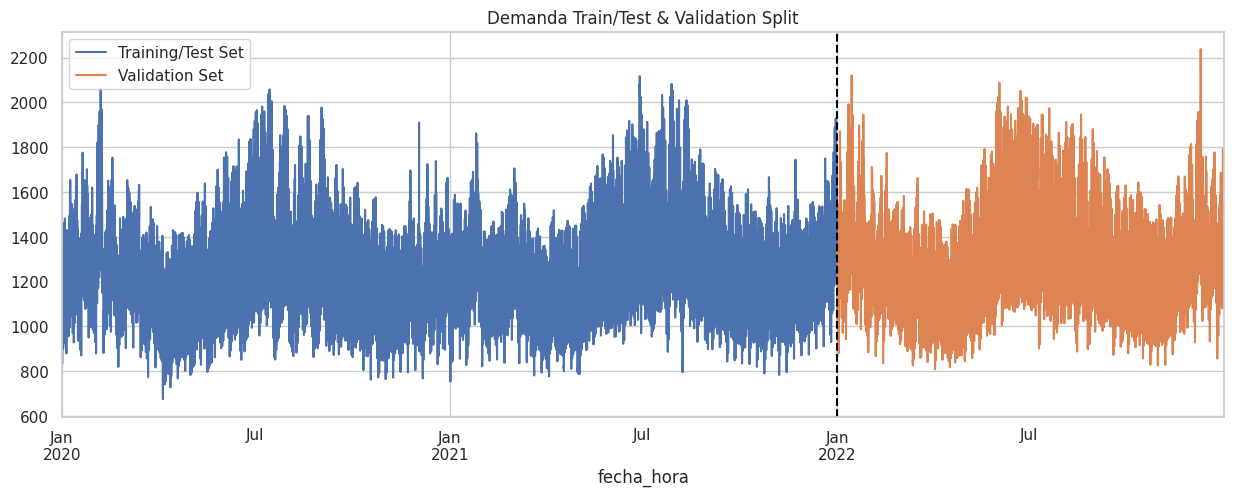

In [ ]:
# Visualización de la division
fig, ax = plt.subplots(figsize=(15, 5))
train_test['demanda'].plot(ax=ax, label='Training/Test Set', title='Demanda Train/Test & Validation Split')
validation['demanda'].plot(ax=ax, label='Validation Set')
ax.axvline('2022-01-01', color='black', ls='--', label='Train/Validation Split')
ax.legend(['Training/Test Set', 'Validation Set'])
plt.show()

## 6. Modelos

### LightGBM Baseline

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4730
[LightGBM] [Info] Number of data points in the train set: 8784, number of used features: 25
[LightGBM] [Info] Start training from score 1252.261491
Error cuadrático medio (MSE) en el conjunto de prueba: 374.69814004118456


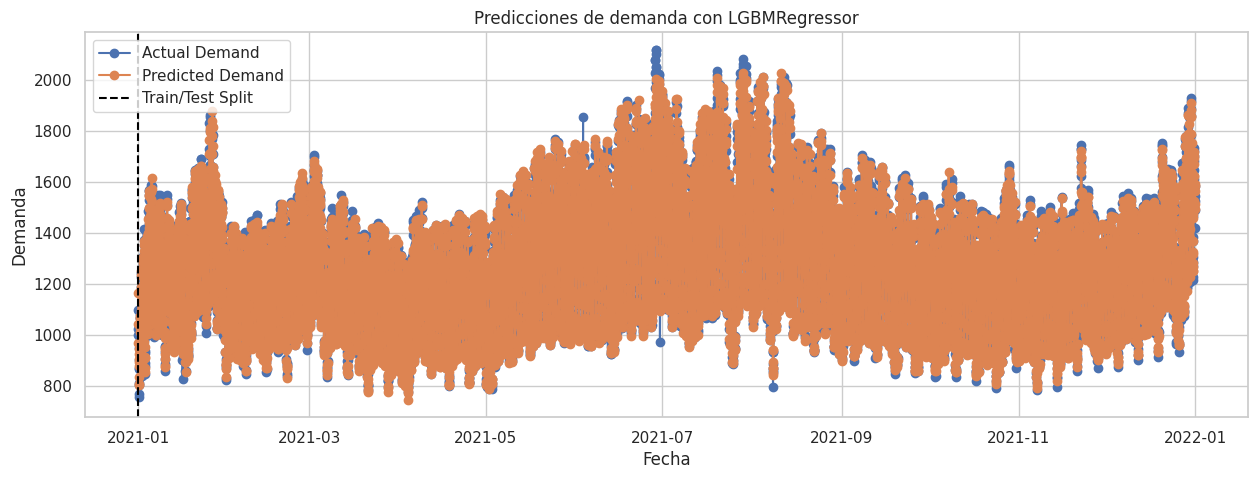

In [ ]:
# Establecer la semilla para reproducibilidad
seed = 2023

# Definir la fecha de división entre train y test (2021-01-01 en este caso)
split_date = datetime.strptime('2021-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

# Filtrar los datos para obtener train y test de acuerdo con la fecha
train = train_test[train_test.index < split_date]
test = train_test[train_test.index >= split_date]

# Definir las características (features) y la variable objetivo (target) para train y test
X_train, y_train = train.drop('demanda', axis=1), train['demanda']
X_test, y_test = test.drop('demanda', axis=1), test['demanda']

# Crear el modelo de LGBMRegressor con la semilla establecida
model = LGBMRegressor(random_state=seed)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE) en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)

print(f"Error cuadrático medio (MSE) en el conjunto de prueba: {mse}")

# Visualizar las predicciones en comparación con los valores reales
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual Demand', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Demand', marker='o')

# Usar el objeto datetime para la línea vertical
plt.axvline(split_date, color='black', ls='--', label='Train/Test Split')

plt.title('Predicciones de demanda con LGBMRegressor')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

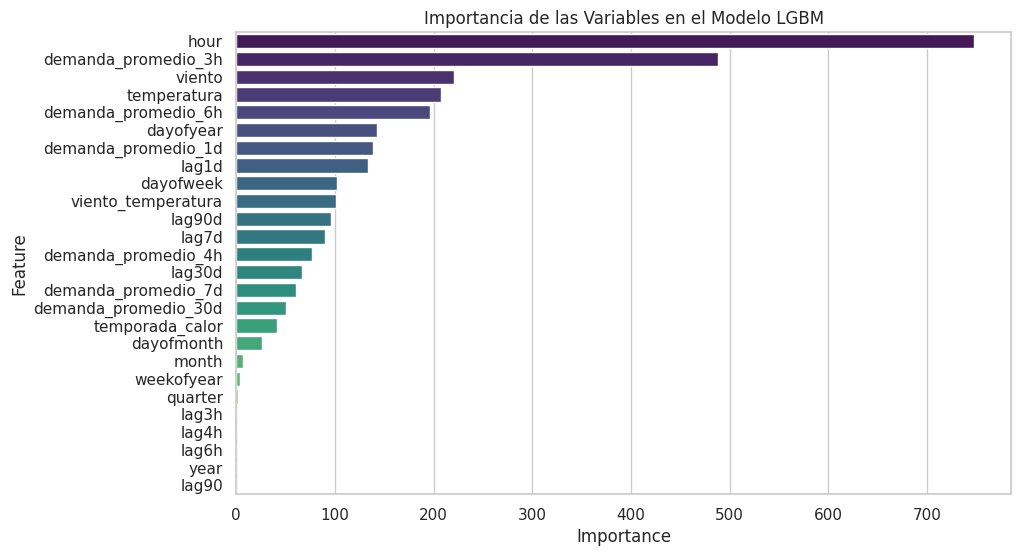

In [ ]:
# Obtener la importancia de las variables
feature_importance = model.feature_importances_

# DataFrame para visualizar las importancias
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizacion
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Variables en el Modelo LGBM')
plt.show()

Error cuadrático medio (MSE) en el conjunto de validación: 526.2717520127231


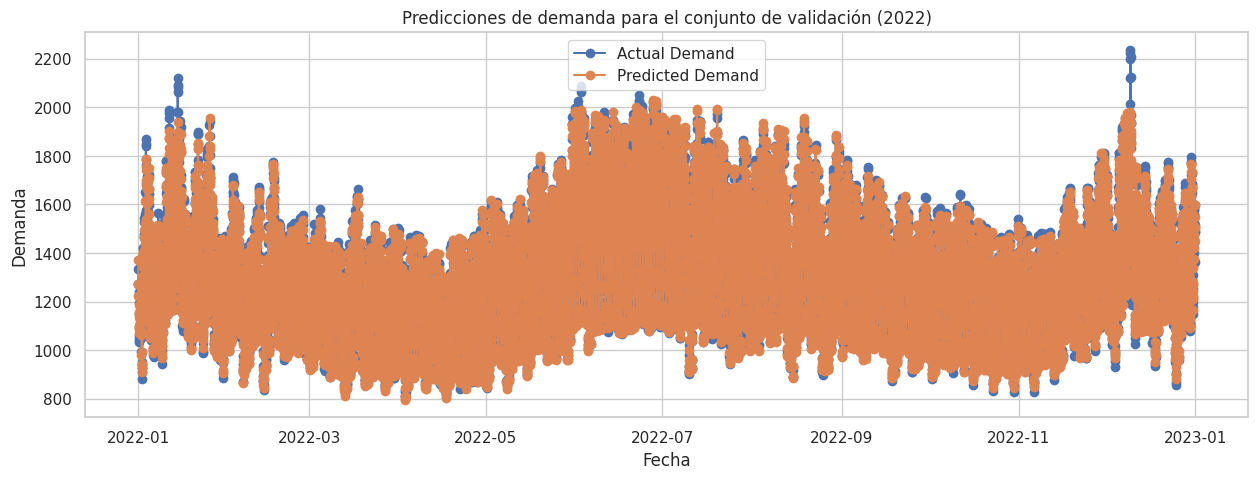

In [ ]:
# Prediccion 2022 y verificacion con el set validiation

# Separar las características y la variable objetivo
X_validation = validation.drop('demanda', axis=1)

# Realizar predicciones para el año 2022
y_pred_validation = model.predict(X_validation)

# Calcular el error cuadrático medio (MSE) en el conjunto de validacion
mse_validation = mean_squared_error(validation['demanda'], y_pred_validation)
print(f"Error cuadrático medio (MSE) en el conjunto de validación: {mse_validation}")

# Visualizar las predicciones en comparación con los valores reales (si tienes datos reales)
y_real_validation = validation['demanda']

plt.figure(figsize=(15, 5))
plt.plot(validation.index, y_real_validation, label='Actual Demand', marker='o')
plt.plot(validation.index, y_pred_validation, label='Predicted Demand', marker='o')
plt.title('Predicciones de demanda para el conjunto de validación (2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

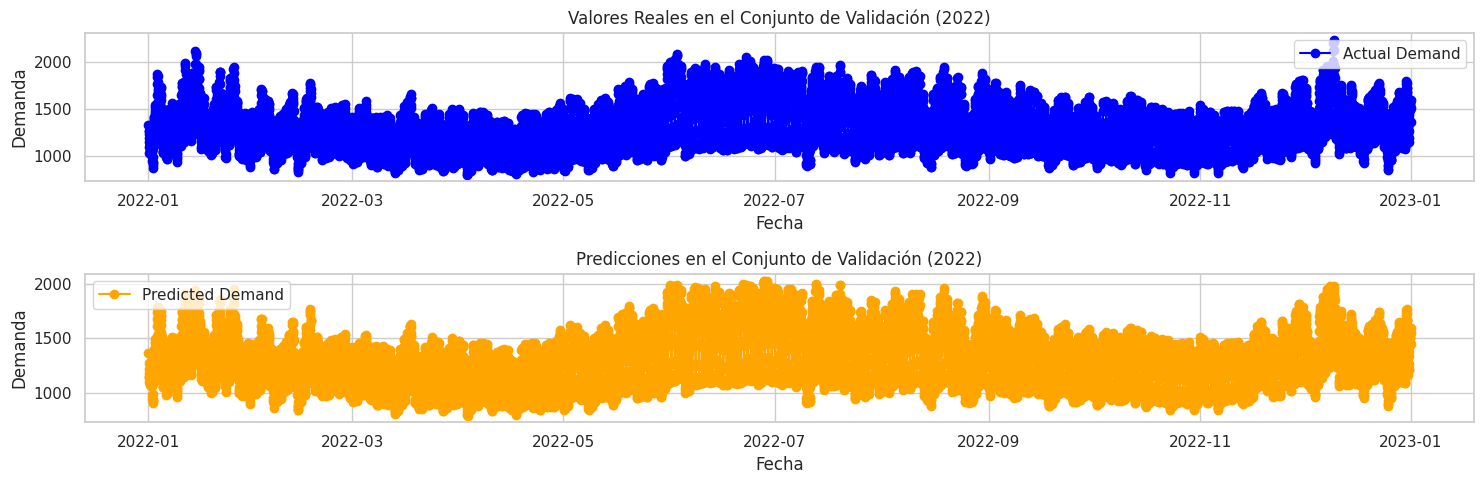

In [ ]:
plt.figure(figsize=(15, 5))

# Gráfico de valores reales en el conjunto de validación
plt.subplot(2, 1, 1)
plt.plot(validation.index, y_real_validation, label='Actual Demand', marker='o', color='blue')
plt.title('Valores Reales en el Conjunto de Validación (2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()

# Gráfico de predicciones en el conjunto de validación
plt.subplot(2, 1, 2)
plt.plot(validation.index, y_pred_validation, label='Predicted Demand', marker='o', color='orange')
plt.title('Predicciones en el Conjunto de Validación (2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()

plt.tight_layout()
plt.show()

### LightGBM con optimizacion bayesiana de hiperparametros y cross validation

In [ ]:
## Almacenar predicciones y resultados de evaluación
#all_y_test = []
#all_y_pred = []
#all_final_mse = []

## Establecer la semilla para reproducibilidad
#seed = 2023

## Dividir los datos en entrenamiento y prueba con validación cruzada de series temporales
#tscv = TimeSeriesSplit(n_splits=5)

#for train_index, test_index in tscv.split(train_test.index):
#    X_train2, X_test2 = train_test.iloc[train_index].drop(['demanda'], axis=1), train_test.iloc[test_index].drop(['demanda'], axis=1)
#    y_train2, y_test2 = train_test.iloc[train_index]['demanda'], train_test.iloc[test_index]['demanda']

#    # Definir la función objetivo para la optimización bayesiana
#    def objective(trial):
#        params = {
#            'objective': 'regression',
#            'metric': 'mse',
#            'boosting_type': 'gbdt',
#            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#            'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
#            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
#            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
#            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
#            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
#            'random_state': seed,  # Establecer la semilla aquí también
#        }

#        model = lgb.LGBMRegressor(**params, n_estimators=1000)

#        model.fit(
#            X_train2, y_train2,
#            eval_set=[(X_test2, y_test2)],
#            eval_metric='mse',
#        )

#        y_pred2 = model.predict(X_test2)
#        mse2 = mean_squared_error(y_test2, y_pred2)
#        return mse2

#    # Optimización
#    study = optuna.create_study(direction='minimize')
#    study.optimize(objective, n_trials=100, n_jobs=-1)

#    # Mejores hiperparámetros encontrados
#    trial = study.best_trial
#    print('Best trial:')
#    print('MSE: {}'.format(trial.value))
#    print('Best hyperparameters: {}'.format(trial.params))

#    # Modelo final con los mejores hiperparámetros
#    best_params = trial.params
#    best_model2 = lgb.LGBMRegressor(**best_params, n_estimators=1000)
#    best_model2.fit(X_train2, y_train2)

#    # Predicciones y evaluar el modelo final
#    y_pred2 = best_model2.predict(X_test2)
#    final_mse2 = mean_squared_error(y_test2, y_pred2)

#    print('Final MSE on test set: {}'.format(final_mse2))

#    # Almacenar resultados
#    all_y_test.extend(y_test2)
#    all_y_pred.extend(y_pred2)
#    all_final_mse.append(final_mse2)

## Visualizar las predicciones en comparación con los valores reales
#plt.figure(figsize=(15, 5))
#plt.plot(train_test.index[-len(all_y_test):], all_y_test, label='Actual Demand', marker='o')
#plt.plot(train_test.index[-len(all_y_pred):], all_y_pred, label='Predicted Demand', marker='o')

## Línea vertical para mostrar el final de los datos de entrenamiento
#plt.axvline(X_train2.index[-1], color='black', ls='--', label='Train/Test Split')

#plt.title('Predicciones de demanda con LGBMRegressor (Series Temporales)')
#plt.xlabel('Fecha')
#plt.ylabel('Demanda')
#plt.legend()
#plt.show()

In [ ]:
## Mejores hiperparámetros encontrados
#best_trial = study.best_trial
#best_params = best_trial.params

#print('Best trial:')
#print('MSE: {}'.format(best_trial.value))
#print('Best hyperparameters: {}'.format(best_params))

In [ ]:
#Best trial:
#MSE: 524.334581217117
#Best hyperparameters: {'num_leaves': 125, 'learning_rate': 0.07099003493441225, 'feature_fraction': 0.9258983566444268, 'bagging_fraction': 0.9151707885914586, 'reg_alpha': 0.11678242675230263, 'reg_lambda': 1.1998147194102671e-09}

[LightGBM] [Warning] feature_fraction is set=0.9258983566444268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258983566444268
[LightGBM] [Warning] bagging_fraction is set=0.9151707885914586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151707885914586
[LightGBM] [Warning] feature_fraction is set=0.9258983566444268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258983566444268
[LightGBM] [Warning] bagging_fraction is set=0.9151707885914586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151707885914586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4493
[LightGBM] [Info] Number of data points in the train set: 2924, number of used features: 25
[LightGBM] [Info] Start training from score 1217.961535
[LightGBM] [Warning] No further splits with positive g

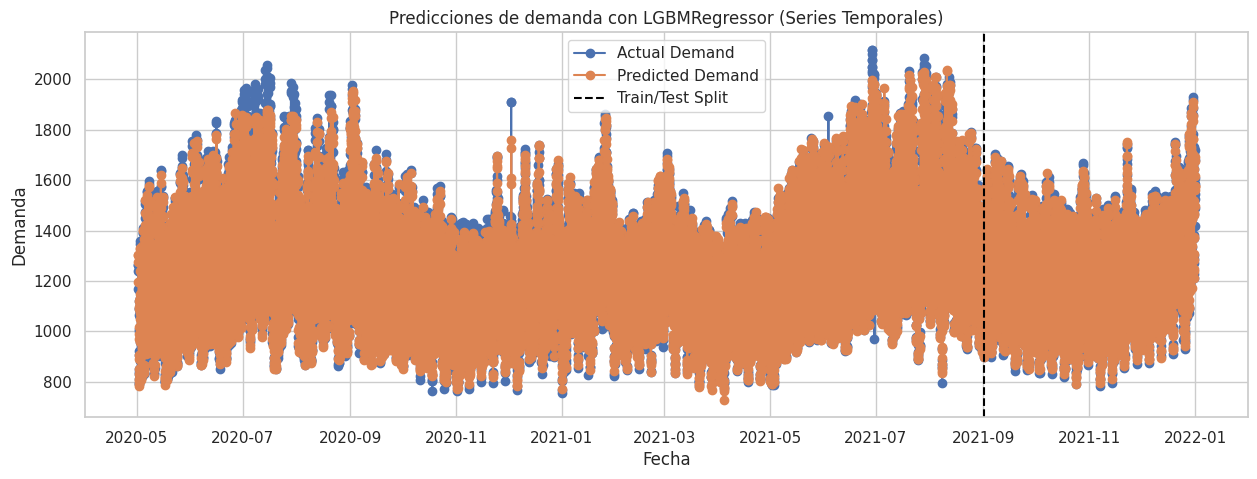

In [ ]:
# Almacenar predicciones y resultados de evaluación
all_y_test = []
all_y_pred = []
all_final_mse = []

# Establecer la semilla para reproducibilidad
seed = 2023

# Dividir los datos en entrenamiento y prueba con validación cruzada de series temporales
tscv = TimeSeriesSplit(n_splits=5)

# Mejores hiperparámetros obtenidos de la optimización bayesiana
best_params = {
    'num_leaves': 125,
    'learning_rate': 0.07099003493441225,
    'feature_fraction': 0.9258983566444268,
    'bagging_fraction': 0.9151707885914586,
    'reg_alpha': 0.11678242675230263,
    'reg_lambda': 1.1998147194102671e-09,
    'random_state': seed,
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
}

for train_index, test_index in tscv.split(train_test.index):
    X_train2, X_test2 = train_test.iloc[train_index].drop(['demanda'], axis=1), train_test.iloc[test_index].drop(['demanda'], axis=1)
    y_train2, y_test2 = train_test.iloc[train_index]['demanda'], train_test.iloc[test_index]['demanda']

    # Modelo final con los mejores hiperparámetros
    best_model2 = lgb.LGBMRegressor(**best_params, n_estimators=1000)
    best_model2.fit(X_train2, y_train2)

    # Predicciones y evaluar el modelo final
    y_pred2 = best_model2.predict(X_test2)
    final_mse2 = mean_squared_error(y_test2, y_pred2)

    print('Final MSE on test set: {}'.format(final_mse2))

    # Almacenar resultados
    all_y_test.extend(y_test2)
    all_y_pred.extend(y_pred2)
    all_final_mse.append(final_mse2)

# Visualizar las predicciones en comparación con los valores reales
plt.figure(figsize=(15, 5))
plt.plot(train_test.index[-len(all_y_test):], all_y_test, label='Actual Demand', marker='o')
plt.plot(train_test.index[-len(all_y_pred):], all_y_pred, label='Predicted Demand', marker='o')

# Línea vertical para mostrar el final de los datos de entrenamiento
plt.axvline(X_train2.index[-1], color='black', ls='--', label='Train/Test Split')

plt.title('Predicciones de demanda con LGBMRegressor (Series Temporales)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

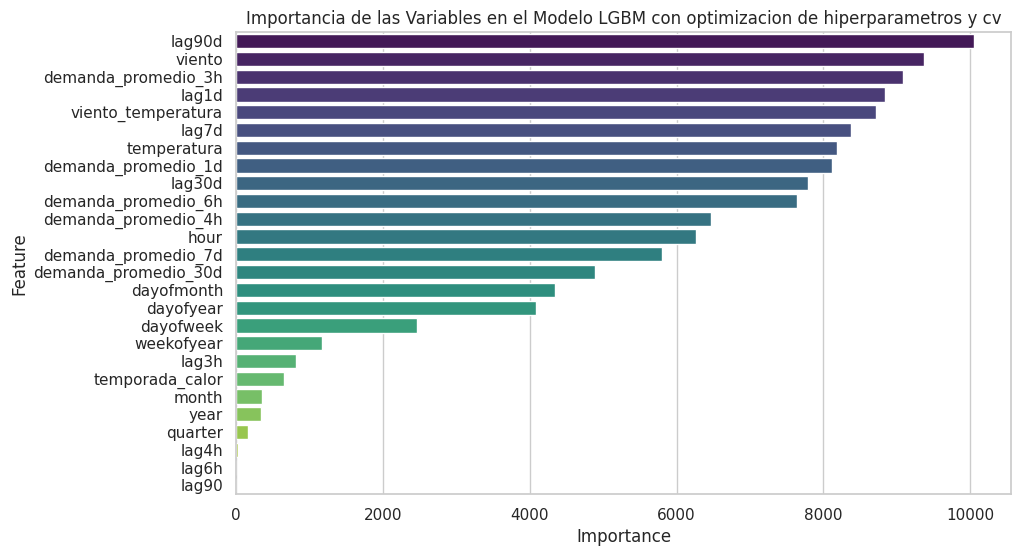

In [ ]:
# Obtener la importancia de las variables
feature_importance = best_model2.feature_importances_

# DataFrame para visualizar las importancias
feature_importance_df = pd.DataFrame({'Feature': X_train2.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizacion
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Variables en el Modelo LGBM con optimizacion de hiperparametros y cv')
plt.show()

[LightGBM] [Warning] feature_fraction is set=0.9258983566444268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258983566444268
[LightGBM] [Warning] bagging_fraction is set=0.9151707885914586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151707885914586
[LightGBM] [Warning] feature_fraction is set=0.9258983566444268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258983566444268
[LightGBM] [Warning] bagging_fraction is set=0.9151707885914586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151707885914586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4733
[LightGBM] [Info] Number of data points in the train set: 17544, number of used features: 26
[LightGBM] [Info] Start training from score 1267.925770
[LightGBM] [Warning] feature_fraction is set=0.925898

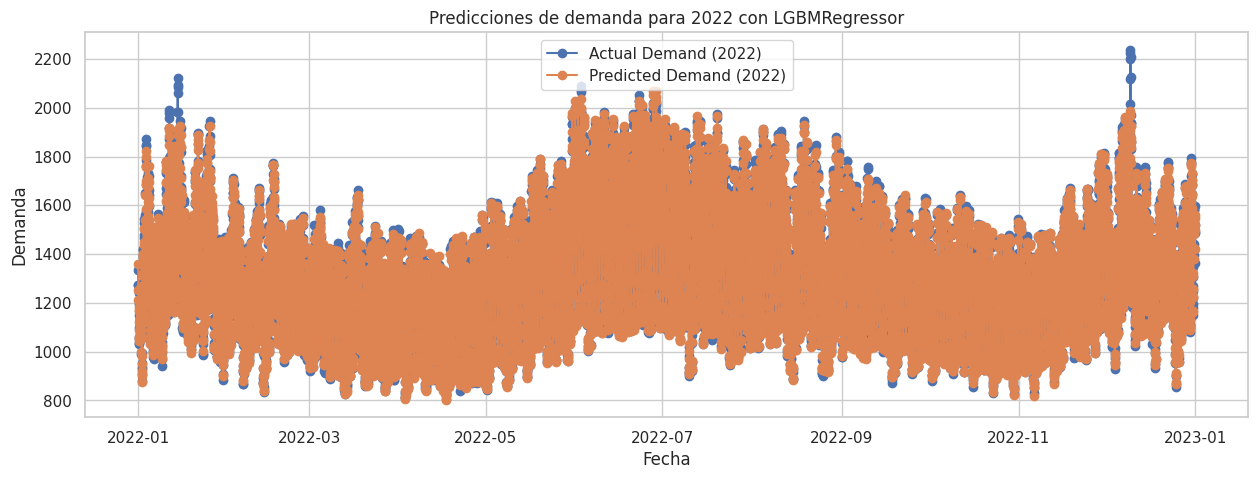

In [ ]:
# Prediccion 2022 y verificacion con el set validiation
# Crear conjuntos de entrenamiento y prueba para el año 2022
train_2022 = train_test[train_test.index.year < 2022]
validation_2022 = validation[validation.index.year == 2022]

X_train_2022 = train_2022.drop(['demanda'], axis=1)
y_train_2022 = train_2022['demanda']
X_validation_2022 = validation_2022.drop(['demanda'], axis=1)
y_validation_2022 = validation_2022['demanda']

# Modelo final con los mejores hiperparámetros
best_model_2022 = lgb.LGBMRegressor(**best_params, n_estimators=1000)
best_model_2022.fit(X_train_2022, y_train_2022)

# Predicciones para el año 2022
y_pred_2022 = best_model_2022.predict(X_validation_2022)
final_mse_2022 = mean_squared_error(y_validation_2022, y_pred_2022)

print('Final MSE on 2022 validation set: {}'.format(final_mse_2022))

# Visualizar las predicciones en comparación con los valores reales para 2022
plt.figure(figsize=(15, 5))
plt.plot(validation_2022.index, y_validation_2022, label='Actual Demand (2022)', marker='o')
plt.plot(validation_2022.index, y_pred_2022, label='Predicted Demand (2022)', marker='o')

plt.title('Predicciones de demanda para 2022 con LGBMRegressor')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4733
[LightGBM] [Info] Number of data points in the train set: 14620, number of used features: 26
[LightGBM] [Info] Start training from score 1271.686628
[LightGBM] [Warning] feature_fraction is set=0.9258983566444268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258983566444268
[LightGBM] [Warning] bagging_fraction is set=0.9151707885914586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151707885914586
[LightGBM] [Warning] feature_fraction is set=0.9258983566444268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258983566444268
[LightGBM] [Warning] bagging_fraction is set=0.9151707885914586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.915170

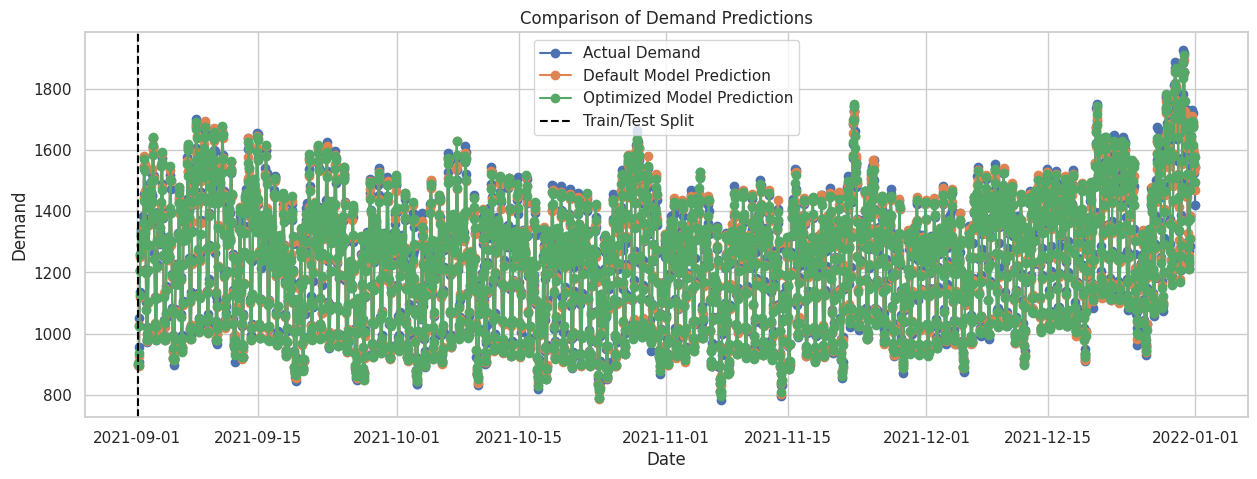

In [ ]:
#Comparar ambos modelos para test

# Modelo sin ajuste de hiperparámetros
default_model = lgb.LGBMRegressor(n_estimators=1000, random_state=seed)
default_model.fit(X_train2, y_train2)
y_pred_default = default_model.predict(X_test2)
mse_default = mean_squared_error(y_test2, y_pred_default)

# Modelo con hiperparámetros optimizados
best_model = lgb.LGBMRegressor(**best_params, n_estimators=1000)
best_model.fit(X_train2, y_train2)
y_pred_best = best_model.predict(X_test2)
mse_best = mean_squared_error(y_test2, y_pred_best)

# Imprimir resultados
print('MSE LightGBM Base: {}'.format(mse_default))
print('MSE Optimizacion de hiperparametros y cv: {}'.format(mse_best))

# Visualizar las predicciones en comparación con los valores reales
plt.figure(figsize=(15, 5))
plt.plot(train_test.index[-len(y_test2):], y_test2, label='Actual Demand', marker='o')
plt.plot(train_test.index[-len(y_pred_default):], y_pred_default, label='Default Model Prediction', marker='o')
plt.plot(train_test.index[-len(y_pred_best):], y_pred_best, label='Optimized Model Prediction', marker='o')
plt.axvline(X_train2.index[-1], color='black', ls='--', label='Train/Test Split')

plt.title('Comparison of Demand Predictions')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

MAE en el conjunto de validación: 16.500135961038428
RMSE en el conjunto de validación: 22.94061359276868


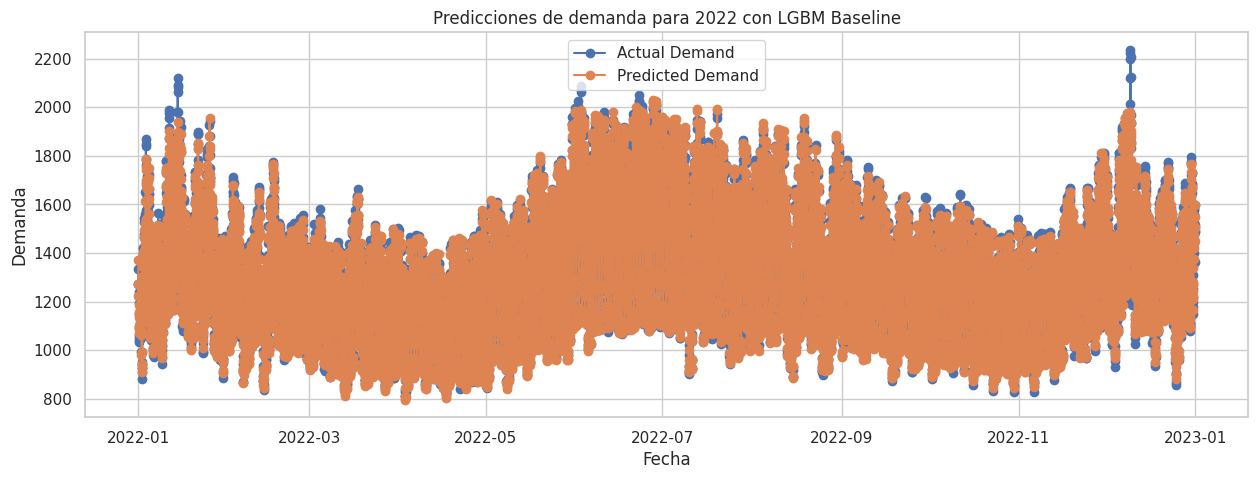

MAE en el conjunto de validación 2022: 13.233514475878534
RMSE en el conjunto de validación 2022: 19.84507478910423


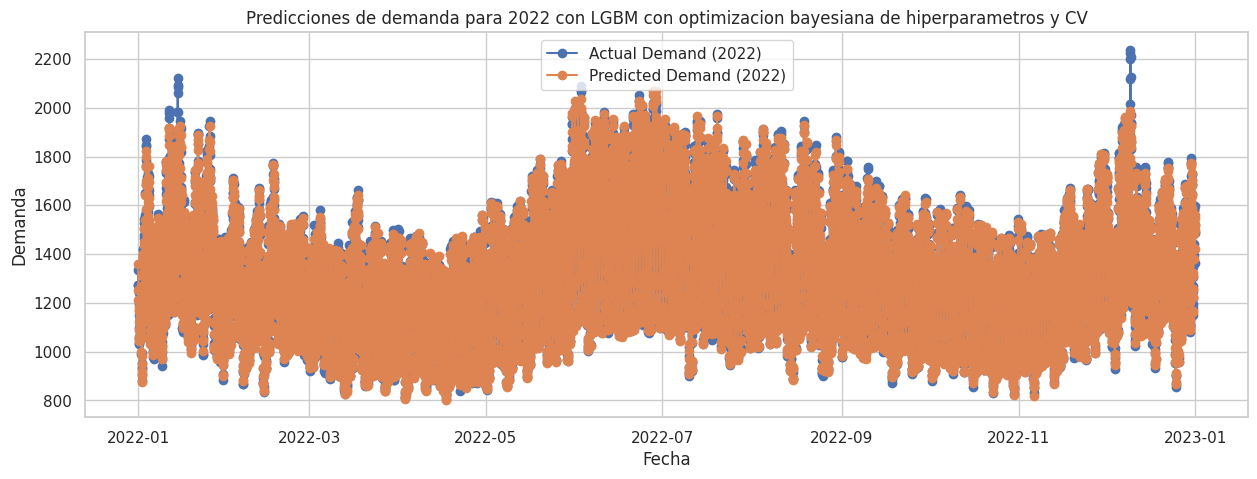

In [ ]:
#Comparar ambos modelos para validation

# Métricas para el primer conjunto de predicciones
mae_validation = mean_absolute_error(validation['demanda'], y_pred_validation)
rmse_validation = np.sqrt(mean_squared_error(validation['demanda'], y_pred_validation))

print(f'MAE en el conjunto de validación: {mae_validation}')
print(f'RMSE en el conjunto de validación: {rmse_validation}')

# Visualizar las predicciones en comparación con los valores reales (si tienes datos reales)
plt.figure(figsize=(15, 5))
plt.plot(validation.index, y_real_validation, label='Actual Demand', marker='o')
plt.plot(validation.index, y_pred_validation, label='Predicted Demand', marker='o')
plt.title('Predicciones de demanda para 2022 con LGBM Baseline')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

# Métricas para el segundo conjunto de predicciones
mae_2022 = mean_absolute_error(y_validation_2022, y_pred_2022)
rmse_2022 = np.sqrt(mean_squared_error(y_validation_2022, y_pred_2022))

print('MAE en el conjunto de validación 2022: {}'.format(mae_2022))
print('RMSE en el conjunto de validación 2022: {}'.format(rmse_2022))

# Visualizar las predicciones en comparación con los valores reales para 2022
plt.figure(figsize=(15, 5))
plt.plot(validation_2022.index, y_validation_2022, label='Actual Demand (2022)', marker='o')
plt.plot(validation_2022.index, y_pred_2022, label='Predicted Demand (2022)', marker='o')

plt.title('Predicciones de demanda para 2022 con LGBM con optimizacion bayesiana de hiperparametros y CV')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

MAE en el conjunto de validación (Hora=20): 20.61938656877396
RMSE en el conjunto de validación (Hora=20): 25.81337465350302


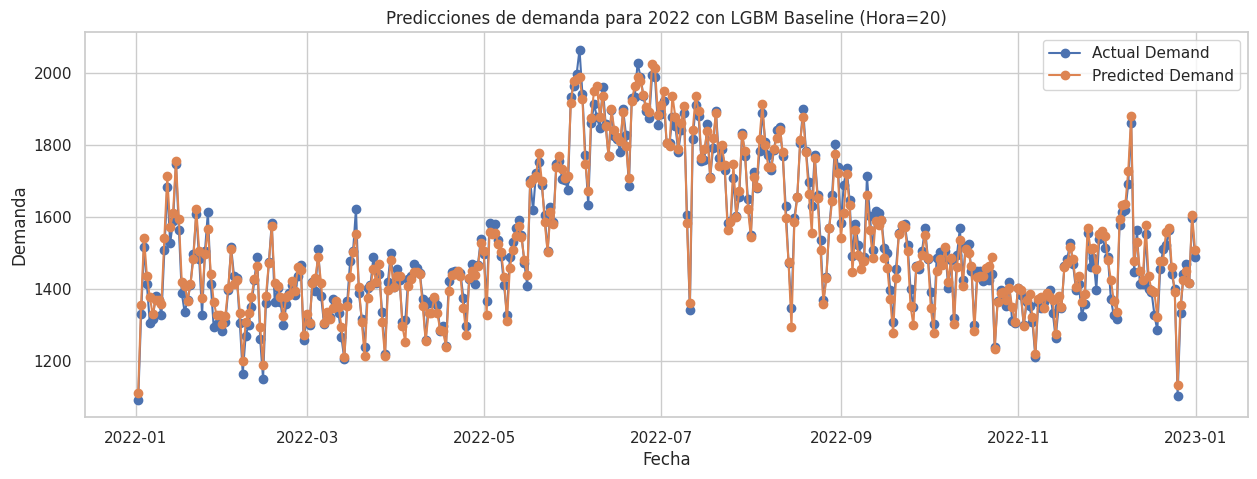

MAE en el conjunto de validación 2022 (Hora=20): 17.52292419731149
RMSE en el conjunto de validación 2022 (Hora=20): 22.599529997743492


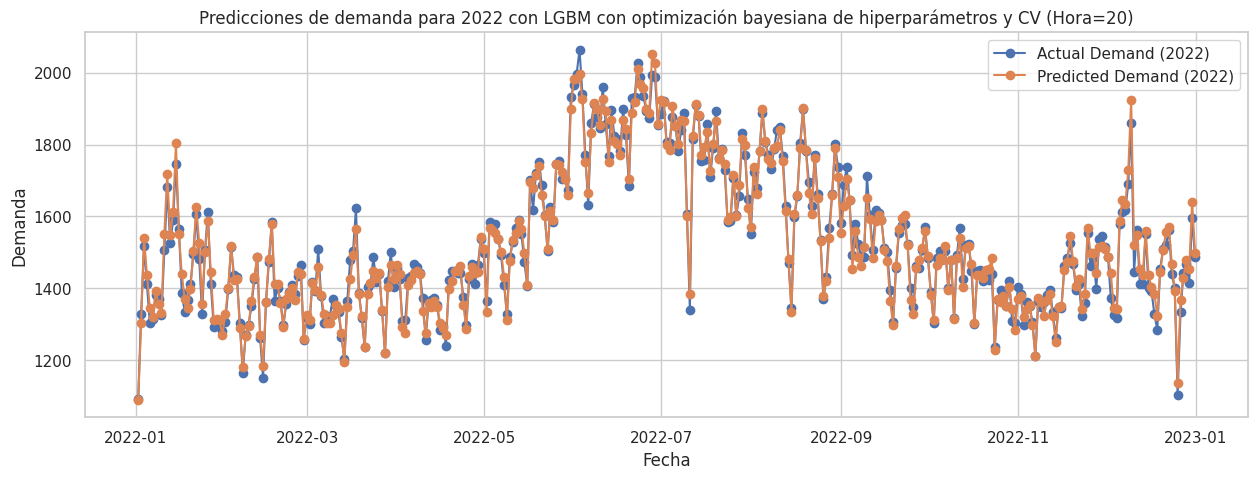

In [ ]:
# Se filtran los datos en una hora especifica para una mejor visualizacion
hour_condition = (validation.index.hour == 20)

# Conjuntos de validación filtrados
validation_filtered = validation[hour_condition]
y_real_validation_filtered = y_real_validation[hour_condition]
y_pred_validation_filtered = y_pred_validation[hour_condition]

# Métricas para el primer conjunto de predicciones filtrado
mae_validation_filtered = mean_absolute_error(validation_filtered['demanda'], y_pred_validation_filtered)
rmse_validation_filtered = np.sqrt(mean_squared_error(validation_filtered['demanda'], y_pred_validation_filtered))

print(f'MAE en el conjunto de validación (Hora=20): {mae_validation_filtered}')
print(f'RMSE en el conjunto de validación (Hora=20): {rmse_validation_filtered}')

# Visualizar las predicciones en comparación con los valores reales (si tienes datos reales) para la hora 20
plt.figure(figsize=(15, 5))
plt.plot(validation_filtered.index, y_real_validation_filtered, label='Actual Demand', marker='o')
plt.plot(validation_filtered.index, y_pred_validation_filtered, label='Predicted Demand', marker='o')
plt.title('Predicciones de demanda para 2022 con LGBM Baseline (Hora=20)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

# Filtrar datos para la hora 20 en 2022
hour_condition_2022 = (validation_2022.index.hour == 20)

# Conjuntos de validación 2022 filtrados
validation_2022_filtered = validation_2022[hour_condition_2022]
y_validation_2022_filtered = y_validation_2022[hour_condition_2022]
y_pred_2022_filtered = y_pred_2022[hour_condition_2022]

# Métricas para el segundo conjunto de predicciones filtrado
mae_2022_filtered = mean_absolute_error(y_validation_2022_filtered, y_pred_2022_filtered)
rmse_2022_filtered = np.sqrt(mean_squared_error(y_validation_2022_filtered, y_pred_2022_filtered))

print('MAE en el conjunto de validación 2022 (Hora=20): {}'.format(mae_2022_filtered))
print('RMSE en el conjunto de validación 2022 (Hora=20): {}'.format(rmse_2022_filtered))

# Visualizar las predicciones en comparación con los valores reales para 2022 (Hora=20)
plt.figure(figsize=(15, 5))
plt.plot(validation_2022_filtered.index, y_validation_2022_filtered, label='Actual Demand (2022)', marker='o')
plt.plot(validation_2022_filtered.index, y_pred_2022_filtered, label='Predicted Demand (2022)', marker='o')

plt.title('Predicciones de demanda para 2022 con LGBM con optimización bayesiana de hiperparámetros y CV (Hora=20)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

## Neural Prophet

In [ ]:
if "google.colab" in str(get_ipython()):
    # uninstall preinstalled packages from Colab to avoid conflicts
    !pip uninstall -y torch notebook notebook_shim tensorflow tensorflow-datasets prophet torchaudio torchdata torchtext torchvision
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: notebook 6.5.5
Uninstalling notebook-6.5.5:
  Successfully uninstalled notebook-6.5.5
Found existing installation: notebook_shim 0.2.3
Uninstalling notebook_shim-0.2.3:
  Successfully uninstalled notebook_shim-0.2.3
Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0
Found existing installation: tensorflow-datasets 4.9.3
Uninstalling tensorflow-datasets-4.9.3:
  Successfully uninstalled tensorflow-datasets-4.9.3
Found existing installation: prophet 1.1.5
Uninstalling prophet-1.1.5:
  Successfully uninstalled prophet-1.1.5
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
Found existing installation: torchdata 0.7.0
Uninstalling torchdata-0.7.0:
  Successfully uninstalled torchd

In [ ]:
# Modelo sin regresor

train_test_copy = train_test.copy()
train_test_copy['ds'] = train_test_copy.index
train_test_copy = train_test_copy[['ds', 'demanda']].rename(columns={'demanda': 'y'})

# Filtrar datos para 2020 y 2021
df_train = train_test_copy['2020']
df_val = train_test_copy['2021']

# Configurar el modelo NeuralProphet sin regresores lagged
model_sin_regresor = NeuralProphet()

# Entrenar el modelo sin regresores lagged
metricas_sin_regresor = model_sin_regresor.fit(df_train, validation_df=df_val, freq='H')

# Mostrar métricas
print("Metrics without regressor:")
print(metricas_sin_regresor)

# Hacer predicciones y visualizar en el conjunto de test
forecast_sin_regresor = model_sin_regresor.predict(df_val)
model_sin_regresor.plot(forecast_sin_regresor)

# Visualización de componentes y parámetros en el conjunto de test
model_sin_regresor.plot_components(forecast_sin_regresor)
model_sin_regresor.plot_parameters()

# Evaluación del modelo en el conjunto de test
metricas_test_sin_regresor = model_sin_regresor.test(df=df_val)
print("Test metrics without regressor:")
print(metricas_test_sin_regresor)

Finding best initial lr:   0%|          | 0/248 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metrics without regressor:
         MAE_val     RMSE_val  Loss_val  RegLoss_val  epoch          MAE  \
0    1314.462280  1417.221313  1.157112          0.0      0  1774.744385   
1     224.797836   247.265900  0.110619          0.0      1   188.188385   
2     235.238846   257.131622  0.119004          0.0      2   117.363541   
3     234.791122   255.834534  0.118780          0.0      3   114.849991   
4     225.778961   248.709412  0.111136          0.0      4   112.007713   
..           ...          ...       ...          ...    ...          ...   
101   115.149063   141.855698  0.034786          0.0    101    89.141693   
102   114.903755   141.051926  0.034493          0.0    102    89.584473   
103   114.559029   140.580643  0.034305          0.0    103    89.140396   
104   115.076241   140.843231  0.034311          0.0    104    89.303757   
105   113.569321   140.295425  0.034471          0.0    105    89.418159   

            RMSE      Loss  RegLoss  
0    2062.636475  1.29

Predicting: 138it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.0344710610806942     │
│          MAE_val          │    113.56932067871094     │
│         RMSE_val          │    140.29542541503906     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Test metrics without regressor:
      MAE_val    RMSE_val  Loss_test  RegLoss_test
0  113.569321  140.295425   0.034471           0.0


Dataset size: 17544
Train dataset size: 8784
Test dataset size: 8760


Finding best initial lr:   0%|          | 0/248 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 138it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.0022928898688405752   │
│          MAE_val          │     27.73979949951172     │
│         RMSE_val          │     37.0708122253418      │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

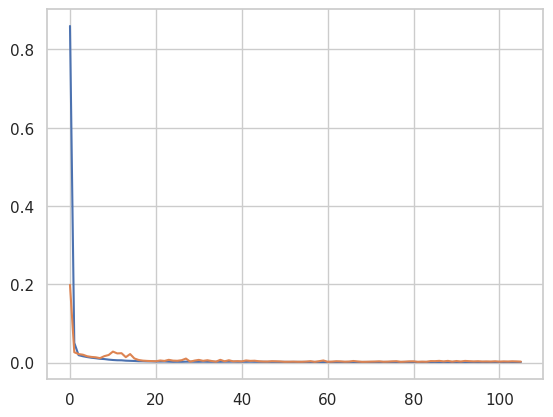

In [ ]:
# Modelo usando temperatura como regresor

train_test_copy_reg = train_test.copy()
train_test_copy_reg['ds'] = train_test_copy_reg.index
train_test_copy_reg = train_test_copy_reg[['ds', 'demanda', 'temperatura']].rename(columns={'demanda': 'y'})

# Convertir 'ds' a tipo datetime
train_test_copy_reg['ds'] = pd.to_datetime(train_test_copy_reg['ds'])

# División de conjuntos de datos para train (2020) y test (2021)
df_train_reg = train_test_copy_reg[train_test_copy_reg['ds'].dt.year == 2020]
df_test_reg = train_test_copy_reg[train_test_copy_reg['ds'].dt.year == 2021]

print("Dataset size:", len(train_test_copy_reg))
print("Train dataset size:", len(df_train_reg))
print("Test dataset size:", len(df_test_reg))

# Inicialización del modelo NeuralProphet con regresor
model_con_regresor = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=10,
)

# Adición de regresor rezagado
model_con_regresor.add_lagged_regressor("temperatura")

# Entrenamiento del modelo con regresor
metricas_con_regresor = model_con_regresor.fit(df_train_reg, validation_df=df_test_reg, progress="plot")

# Predicción y visualización en el conjunto de test
forecast_con_regresor = model_con_regresor.predict(df_test_reg)
model_con_regresor.plot(forecast_con_regresor)

# Visualización de componentes y parámetros
model_con_regresor.plot_components(forecast_con_regresor, components=["lagged_regressors"])
model_con_regresor.plot_parameters(components=["lagged_regressors"])

# Evaluación del modelo en el conjunto de test
metricas_test_con_regresor = model_con_regresor.test(df=df_test_reg)

In [ ]:
# Predicciones 2022

# Copiar los datos de validación y prepararlos para el modelo sin regresor
validation_copy = validation.copy()
validation_copy['ds'] = validation_copy.index
validation_copy = validation_copy[['ds', 'demanda']].rename(columns={'demanda': 'y'})

# Copiar los datos de validación y prepararlos para el modelo con regresor
validation_copy2 = validation.copy()
validation_copy2['ds'] = validation_copy2.index
validation_copy2 = validation_copy2[['ds', 'demanda', 'temperatura']].rename(columns={'demanda': 'y'})

# Realizar predicciones para 2022 con el modelo sin regresor
forecast_sin_regresor_2022 = model_sin_regresor.predict(validation_copy)

# Realizar predicciones para 2022 con el modelo con regresor
forecast_con_regresor_2022 = model_con_regresor.predict(validation_copy2)
forecast_con_regresor_2022 = forecast_con_regresor_2022.dropna(subset=['yhat1'])

# Dado que por el lag forecast_con_regresor_2022 tiene los primeros registros nulos, se eliminan dichos registros de validation_copy2
validation_copy2 = validation_copy2.iloc[:len(forecast_con_regresor_2022)]

# Calcular el MAE para el modelo sin regresor
mae_sin_regresor = mean_absolute_error(validation_copy['y'], forecast_sin_regresor_2022['yhat1'])
print("MAE without regressor:", mae_sin_regresor)

# Calcular el MAE para el modelo con regresor
mae_con_regresor = mean_absolute_error(validation_copy2['y'], forecast_con_regresor_2022['yhat1'])
print("MAE with regressor:", mae_con_regresor)

Predicting: 138it [00:00, ?it/s]

Predicting: 138it [00:00, ?it/s]

MAE without regressor: 148.4667808656054
MAE with regressor: 276.3986785061061


### Comparativa de modelos LGBM y NeuralProphet

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd

# Métricas para el primer conjunto de predicciones (y_pred_validation)
mae_validation = mean_absolute_error(validation['demanda'], y_pred_validation)
r2_validation = r2_score(validation['demanda'], y_pred_validation)
mape_validation = mean_absolute_percentage_error(validation['demanda'], y_pred_validation)

# Métricas para el segundo conjunto de predicciones (y_pred_2022)
mae_2022 = mean_absolute_error(y_validation_2022, y_pred_2022)
r2_2022 = r2_score(y_validation_2022, y_pred_2022)
mape_2022 = mean_absolute_percentage_error(y_validation_2022, y_pred_2022)

# Métricas para el modelo sin regresor (forecast_sin_regresor_2022)
mae_sin_regresor = mean_absolute_error(validation_copy['y'], forecast_sin_regresor_2022['yhat1'])
r2_sin_regresor = r2_score(validation_copy['y'], forecast_sin_regresor_2022['yhat1'])
mape_sin_regresor = mean_absolute_percentage_error(validation_copy['y'], forecast_sin_regresor_2022['yhat1'])

# Métricas para el modelo con regresor (forecast_con_regresor_2022)
mae_con_regresor = mean_absolute_error(validation_copy2['y'], forecast_con_regresor_2022['yhat1'])
r2_con_regresor = r2_score(validation_copy2['y'], forecast_con_regresor_2022['yhat1'])
mape_con_regresor = mean_absolute_percentage_error(validation_copy2['y'], forecast_con_regresor_2022['yhat1'])

# Cuadro resumen
data = {
    'Modelo': ['LGBM Baseline', 'LGBM con Optimización Bayesiana y CV', 'NeuralProphet Sin Regresor', 'NeuralProPhet con Temperatura como Regresor'],
    'MAE': [mae_validation, mae_2022, mae_sin_regresor, mae_con_regresor],
    'R²': [r2_validation, r2_2022, r2_sin_regresor, r2_con_regresor],
    'MAPE': [mape_validation, mape_2022, mape_sin_regresor, mape_con_regresor]
}

df_resultados = pd.DataFrame(data)
titulo = "## Predicción Demanda 2022"
print(titulo)
print(df_resultados.to_markdown(index=False))

## Predicción Demanda 2022
| Modelo                                      |      MAE |        R² |       MAPE |
|:--------------------------------------------|---------:|----------:|-----------:|
| LGBM Baseline                               |  16.5001 |  0.991381 | 0.0121895  |
| LGBM con Optimización Bayesiana y CV        |  13.2335 |  0.99355  | 0.00966988 |
| NeuralProphet Sin Regresor                  | 148.467  |  0.493199 | 0.115787   |
| NeuralProPhet con Temperatura como Regresor | 276.399  | -0.784068 | 0.210879   |


In [ ]:
# Se reestablece el entorno tal como estaba antes de la instalacion de NeuralProphet para lo cual se tuvieron que desintalar algunas librerias
# Desinstalar NeuralProphet
#!pip uninstall -y neuralprophet

# Instalar las versiones originales de los paquetes desinstalados
#!pip install torch notebook notebook_shim tensorflow tensorflow-datasets prophet torchaudio torchdata torchtext torchvision

In [ ]:
# Métricas para el modelo sin regresor (forecast_sin_regresor_2022)
mae_sin_regresor = mean_absolute_error(validation_copy['y'], forecast_sin_regresor_2022['yhat1'])
r2_sin_regresor = r2_score(validation_copy['y'], forecast_sin_regresor_2022['yhat1'])
mape_sin_regresor = mean_absolute_percentage_error(validation_copy['y'], forecast_sin_regresor_2022['yhat1'])

# Analisis de Diagnostico


## Funcion Customizada para el analis de los Residuos

In [ ]:
# Libreria importada del TP#1 para el analisis de residuos

# Instalacion y carga
!pip install pingouin
!pip install pmdarima

import pingouin as pg
import statsmodels.api as sm
from scipy.stats import jarque_bera
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from pmdarima.arima.utils import ndiffs

# Diferentes Tests de Normalidad
def residuos_normality(residuos):
  # Test Grafico
  pg.qqplot(residuos, dist='norm')
  plt.title('Normalidad de los Residuos')
  plt.show()

  # Test Analitico
  jarquebera = jarque_bera(residuos)[1]
  shapir = shapiro(residuos)[1]
  print('Shapiro p-value:', np.round(shapir, 3))
  print('Jarque-Bera p-value:', np.round(jarquebera, 3), '\n')

# Diferentes Tests de Autocorrelacion
def residuos_autocorrelation(residuos):
  # Test Grafico
  plot_acf(residuos, lags=len(residuos)-1)
  plt.title('Autocorrelacion de los Residuos')
  plt.show()
  # Tests Analiticos
  dw = sm.stats.stattools.durbin_watson(residuos)
  lb = sm.stats.acorr_ljungbox(residuos, lags=len(residuos)-1, return_df=True)
  print('Durbin-Watson (~2 = No-Autocorrelation):', np.round(dw, 3))
#   print('Ljung-Box p-value:', lb.lb_pvalue.values[3])

# Test Grafico de Homocedasticidad, el Analitco no lo pude hacer funcionar
def residuos_homocedasticity(residuos):
  # Grafico
  plt.scatter(range(len(residuos)), residuos)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.xlabel('Tiempo')
  plt.ylabel('Residuos')
  plt.title('Homocedasticidad - Residuos a lo Largo del Tiempo')
  plt.show()

  # Analitico
  X = np.arange(len(residuos))
  X_with_const = sm.add_constant(X)
  print('Breusch-Pagan p-value (H0: Homocedasticity):', het_breuschpagan(residuos, X_with_const)[1].round(3))

# Llama a todos los test anteriores, mas la media
def residuos_evaluation(residuos):
  print('Media de los Residuos', np.round(residuos.mean(), 3))
  residuos_normality(residuos)
  residuos_autocorrelation(residuos)
  residuos_homocedasticity(residuos)


# Para obtener el d optimo a diferenciar
def diferenciacion(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)
  print('Estimado de número de diferencias con ADF test')
  print(n_adf)
  print('Estimado de número de diferencias con PP test')
  print(n_pp)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=5306950bd51551dff9e82da9b2aca2074967c5532e91851fd7e10b758a4e6c1a
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00


## LGBM con Optimización Bayesiana y CV

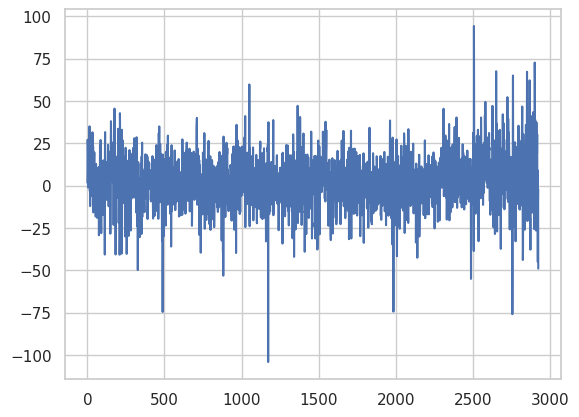

Media de los Residuos 2.935


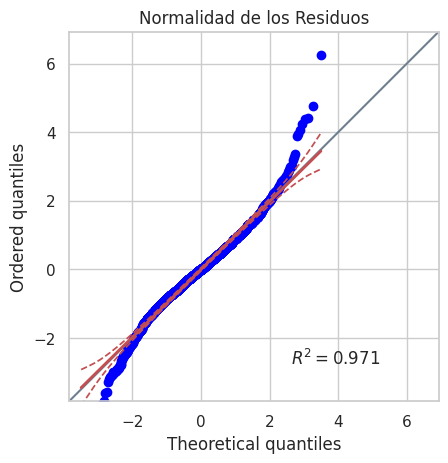

Shapiro p-value: 0.0
Jarque-Bera p-value: 0.0 



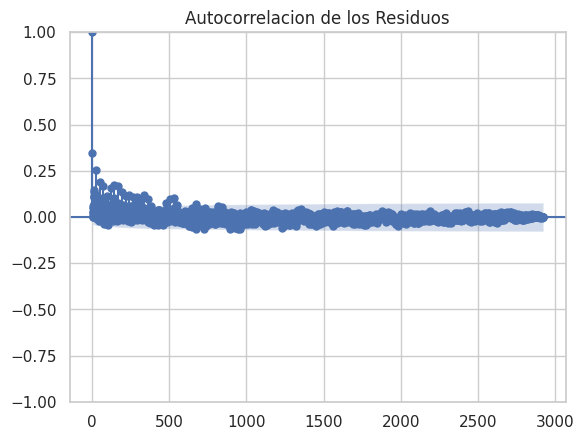

Durbin-Watson (~2 = No-Autocorrelation): 1.248


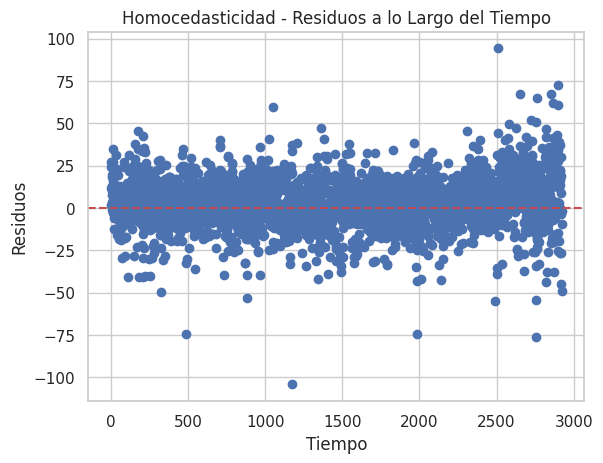

Breusch-Pagan p-value (H0: Homocedasticity): 0.0


In [ ]:
# Rafa please confirma si los vectores de Test y Pred son los correctos para este modelo (LGBM con Opt)
# Calculo los residuos a mano
residuos_lgbm_con_opt = (y_test2.reset_index(drop=True)) - y_pred_default
residuos_lgbm_con_opt.plot()
plt.show()

# (residuos_lgbm_con_opt < -200)
# plt.plot(y_pred_default)
# y_test2.plot()

# Llamo a la Funcion
residuos_evaluation(residuos_lgbm_con_opt)

* Feos los residuos

## NeuralProphet Sin Regresor

Media de los Residuos -67.811


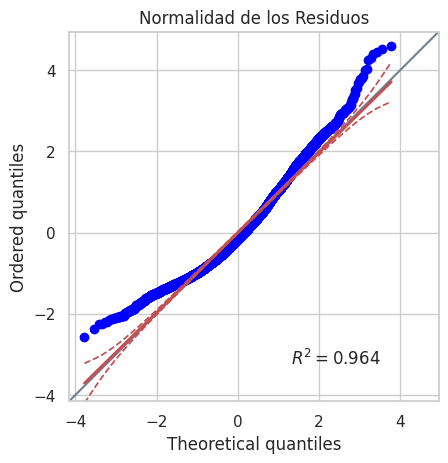

Shapiro p-value: 0.0
Jarque-Bera p-value: 0.0 



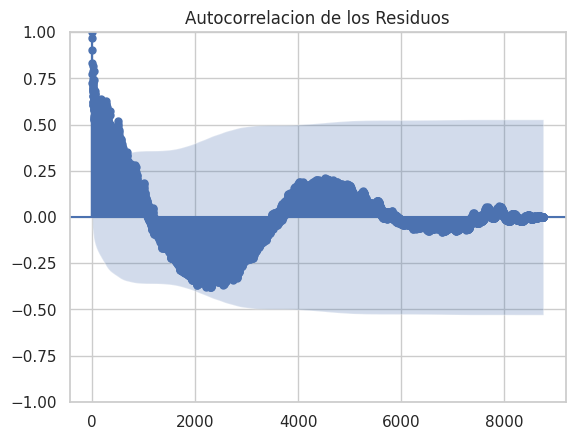

Durbin-Watson (~2 = No-Autocorrelation): 0.053


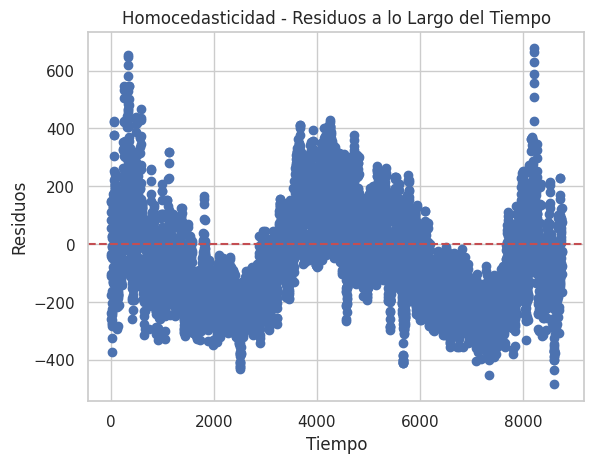

Breusch-Pagan p-value (H0: Homocedasticity): 0.0


In [ ]:
# Rafa please confirma si los vectores de Test y Pred son los correctos para este modelo (NP sin Regresor)
# Calculo los residuos a mano
residuos_np_sin_reg = (validation_copy['y']).reset_index(drop=True) - (forecast_sin_regresor_2022['yhat1']).reset_index(drop=True)

# Llamo a la Funcion
residuos_evaluation(residuos_np_sin_reg)

# residuos_np_sin_reg.plot()

* Feos los rediduos